# First Analysis of the Experiment Data

In this notebook we analyze the first results from the 50 experiment parameters as defined in [parameters.py](project_code/parameters.py). These parameters have been run and fed to experiment classes ([experiments2.py](project_code/experiments2.py)) in [data_validation.ipynb](data_validation.ipynb). This process is computationally intensive due to the method of utilizing search templates, requiring about 30 minutes of processing. A pickled version of the data is exported by that notebook which is imported here.

The bulk of this analysis notebook takes place in the similarity analysis below, where we take the top 10 most common verbs and analyze their top 5 matches based on averaged scores across all applicable experiment parameters.

### Load and Prepare Data

In [1]:
import numpy as np
import pandas as pd
import collections, os, sys, random, time, pickle, dill, copy, re
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from tf.fabric import Fabric
from tf.extra.bhsa import Bhsa
from project_code.experiments2 import Experiment
from project_code.semspace import SemSpace

bhsa_data_paths=['~/github/etcbc/bhsa/tf/c',
                 '~/github/verb_semantics/project_code/lingo/heads/tf/c',
                 '~/github/verb_semantics/project_code/sdbh']

TF = Fabric(bhsa_data_paths)
tf_api = TF.load('''
                function lex lex_utf8 vs language
                pdp freq_lex gloss domain ls
                mother rela typ sp st code txt instruction
                heads prep_obj 
                prs prs_gn prs_nu prs_ps
                sem_domain sem_domain_code
              ''', silent=True)

tf_api.makeAvailableIn(globals())
B = Bhsa(api=tf_api, name='', version='c')

This is Text-Fabric 5.3.3
Api reference : https://dans-labs.github.io/text-fabric/Api/General/
Tutorial      : https://github.com/Dans-labs/text-fabric/blob/master/docs/tutorial.ipynb
Example data  : https://github.com/Dans-labs/text-fabric-data

118 features found and 0 ignored


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="{provenance of this corpus}">BHSA</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="{CORPUS.upper()} feature documentation">Feature docs</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/Bhsa/" title="BHSA API documentation">BHSA API</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/" title="text-fabric-api">Text-Fabric API 5.3.3</a> <a target="_blank" href="https://dans-labs.github.io/text-fabric/Api/General/#search-templates" title="Search Templates Introduction and Reference">Search Reference</a>

In [2]:
print('Loading cached experiments...')
with open('/Users/cody/Documents/experiments.dill', 'rb') as infile:
    experiments = dill.load(infile)
    print(f'{len(experiments)} experiments loaded.')

Loading cached experiments...
50 experiments loaded.


In [3]:
print('Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...')

spaces = dict((exp_name, SemSpace(exp, info=False)) for exp_name, exp in experiments.items())

print(f'{len(spaces)} experiments successfully loaded into semantic spaces.')

Loading semantic space data: adjusting counts with pmi, preparing plotter functions, etc...
50 experiments successfully loaded into semantic spaces.


## Experiments and their Dimensions

In [6]:
print('Experiments (coocurring features x target words):\n')
for shape, exp in sorted((experiments[exp].data.shape, exp) for exp in experiments):
    print(f'{exp}:\t{shape}')

Experiments (coocurring features x target words):

vi_subj_animacy:	(2, 180)
vi_allarg_pa:	(2, 694)
vi_objc_pa:	(2, 714)
vi_adj+_pa:	(2, 734)
vi_cmpl_pa:	(2, 734)
vi_coad_pa:	(2, 734)
vf_obj_pa:	(3, 694)
vd_domain_simple:	(3, 704)
vf_cmpl_pa:	(4, 725)
vi_objc_animacy:	(5, 173)
vf_adju_pa:	(7, 733)
vf_obj_animacy:	(8, 127)
vf_coad_pa:	(8, 734)
vg_tense:	(8, 734)
vi_cmpl_animacy:	(39, 174)
vf_argAll_pa:	(43, 703)
vi_adj+_animacy:	(46, 108)
vi_coad_animacy:	(51, 241)
vd_domain_embed:	(73, 646)
vf_cmpl_animacy:	(88, 158)
vi_allarg_animacy:	(92, 370)
vf_adju_animacy:	(96, 78)
vf_coad_animacy:	(200, 192)
vi_subj_domain:	(247, 231)
vd_par_lex:	(305, 365)
vf_argAll_animacy:	(378, 207)
vi_objc_domain:	(448, 245)
vf_obj_domain:	(584, 213)
vi_cmpl_domain:	(1033, 223)
vf_cmpl_domain:	(1128, 207)
vi_adj+_domain:	(1219, 217)
vf_adju_domain:	(1575, 180)
vi_coad_domain:	(1735, 386)
vi_subj_lex:	(1959, 290)
vi_objc_lex:	(2251, 305)
vi_allarg_domain:	(2902, 527)
vf_obj_lex:	(3012, 274)
vf_coad_domain:	(

Experiments are coded by their strategy, the verbal argument they are denoting, and the particular level of information they are recording for the given verbal argument:

> strategy_verbArgument_dataPoint

There are 4 strategies: 
* `vi` - Verb inventory (`vi`) makes inventories of verbal arguments based on their simple presence within the clause. The presence of multiple instances will be counted multiple times. 
* `vf` - Verb frame (`vf`) experiments take into account all elements at once within the clause. If multiple instances are present, they are all recorded into a single string or frame. 
* `vd` - Verb domain experiments (`vd`) create an inventory of surrounding words within a given discourse or context. 
* `vg` - The single verb grammar experiment (`vg`) simply measures how often a term occurs in a specific verbal tense, based on the assumption that similar verbs might also prefer similar tenses.

The arguments which are tested by verb inventory and frame experiments are as follows:
* `subj` - subject, which is only counted by verb inventory experiments
* `objc` - object
* `cmpl` - complement (including lexicalized preposition info, e.g. L+COMPLEMENT)
* `adj+`/`adju` - adjunct, which includes tags for location, time, and predicate adjuncts (hence the + sign) (including lexicalized preposition info).
* `coad` - complement and adjuncts together (including lexicalized preposition info)
* `allArg` - object, complement, and adjunct arguments together (including lexicalized preposition info)

For verb domain we test the following contexts that enclose the verb:
* simple_domain - i.e. `N`, `Q`, `D` for narrative, quotation, discourse
* domain_embed - these are the nested codes of simple_domainl like NQ (quotation within narrative)
* con_chain - this gathers terms (excluding stop words) across a clause chain for all of the clause's daughter clauses
* con_clause - this gathers terms (excluding stop words) across the enclosing clause
* con_window - this gathers terms within a window of 2 to the left and right of the verb
* par_lex - this looks at instances of parallelism in poetry to find corresponding verbs between various bicola

Data points which are gathered for all of these categories are:
* pa - the simple presence/absence of a given verbal argument. Absent values receive a null string (ø)
* lex - lexemes of the coocurring terms
* domain - semantic domain of the cooccuring terms based on the Semantic Dictionary of Biblical Hebrew (De Blois, UBS). NB these semantic "domains" are different from verb discourse data (domain) listed above.
* animacy - the animacy of a given term based on a custom mapping to SDBH semantic domains

#### Count Adjustments 

For experiments that include a lot of lexical data, we employ the positive pointwise mutual information score or PPMI to adjust the raw counts (following Levshina 2015, 327). But for experiments with small-scale, categorical variables this does not make sense. The goal with categorical data is not to weigh surprising lexical occurrences, but to measure tendencies. For these it is more appropriate to use a ratio normalization.

Animacy experiments contain mixtures of lexical and categorical data. But lexical data is minimal in experiments that do not strongly weigh prepositional phrases such as object experiments. Thus, for these experiments we normalize with a ratio rather than ppmi. By contrast to the vf_obj_animacy experiment, which has 8 unique values, the vf_adju_animacy and vf_cmpl_animacy experiments have 96 and 200 unique values, respectively. These are more suitable for ppmi adjustment.

In [7]:
countType = {}

for exp_name, exp in experiments.items():
    if exp.data.shape[0] < 9:
#         print(exp_name)
#         print(list(exp.data.index.unique()))
#         print()
        countType[exp_name] = 'sim_rRatio_maxNorm'
    else:
        countType[exp_name] = 'sim_pmi_maxNorm'

## Deriving a Verb Specimen Set

Which verbs will comprise this study? This depends on which verbs are accounted for in the dataset. The presence/absence (pa) experiments count the most basic features, namely, the simple presence or absence of a given verbal argument: objects, complements, adjuncts. I will first try to derive a specimen set by taking the intersection of all the pa experiments.

In [8]:
specimens = set(experiments['vi_objc_pa'].data.columns)
freq_count = collections.Counter()
print(f'Starting with specimens count of {len(specimens)}')

for exp_name, experiment in experiments.items():
    
    if not 'vi_objc_pa' or not re.match('.*_pa', exp_name): # skip first pa experiments or non-pa exps.
        continue
        
    exp_lexemes = set(experiment.data.columns)
    specimens = exp_lexemes & specimens
    
    # make frequency count of lexemes
    for lex in experiment.data.columns:
        if lex in specimens:
            freq_count[lex] += experiment.data[lex].sum()
    
print(f'Complete with specimen count of {len(specimens)}')

Starting with specimens count of 714
Complete with specimen count of 292


### Count Lexemes without Stems

All verbs have their stem appended. How many plain lexemes are in the specimen set?

In [9]:
plain_lexs = set(lex.split('.')[0] for lex in specimens)
lex_nodes = [(next(l for l in F.otype.s('lex') if F.lex.v(l) == lex),) for lex in plain_lexs]

print(f'Number of plain lexemes accounted for: {len(plain_lexs)}\n')
B.show(lex_nodes)

Number of plain lexemes accounted for: 238



We have a good and diverse dataset here. Let's see what the makeup of stems are.

### Stem Counts

In [10]:
stem_counts = collections.Counter(lex.split('.')[1] for lex in specimens)

stem_counts.most_common()

[('qal', 165),
 ('hif', 57),
 ('piel', 40),
 ('nif', 24),
 ('hit', 4),
 ('hsht', 1),
 ('hof', 1)]

## Coverage of Specimens throughout the Experiments

There are 297 verb specimens present with 243 plain lexical forms. Note that many of the experiments have different numbers of specimens present, due to the various requirements per experiment. We intend to use as much data as is present to inform the verb clustering. But are there some verbs whose coverage throughout all 50 experiments is especially lacking?

Below we count per lexeme how many different experiments it occurs in. The number itself is then counted.

In [11]:
spread_count = collections.Counter()
accounted_exps = set()

for lex in specimens:
    count = 0
    for exp_name, exp in experiments.items():
        if lex in exp.data.columns:
            count += 1
            accounted_exps.add(exp_name)
    spread_count[count] += 1
    
spread_count.most_common()

[(50, 26),
 (17, 14),
 (48, 14),
 (44, 13),
 (25, 13),
 (41, 12),
 (21, 11),
 (40, 11),
 (19, 11),
 (49, 10),
 (42, 10),
 (18, 10),
 (32, 10),
 (29, 9),
 (23, 8),
 (37, 8),
 (34, 8),
 (39, 8),
 (46, 7),
 (36, 7),
 (33, 7),
 (22, 7),
 (30, 6),
 (24, 6),
 (31, 6),
 (26, 5),
 (27, 5),
 (43, 5),
 (47, 5),
 (38, 4),
 (20, 4),
 (45, 4),
 (35, 3),
 (28, 2),
 (16, 2),
 (15, 1)]

What is the lowest accounted-for lexemes and how many of them are there?

In [12]:
min(spread_count.most_common())

(15, 1)

In [13]:
sum([amount for count, amount in spread_count.most_common() if count<20])

38

In [14]:
38/297 # ratio of total specimens within 20 or less experiments

0.12794612794612795

Only 1 lexeme is accounted for in only 15 of the experiments. 38 of the 297 verb specimens (12%) have less than 20 applicable experiments. These are acceptable amounts. Verbs that do not have an attested object, for instance, will not appear in 3 of 4 object experiments. But they *will* occur in the presence/absence object experiment. So it can be expected that certain verbs will be less accounted-for in various experiments.

## Examining Distributions of Presence/Absence Inventory Experiments

Presence/absence experiments test whether and how often a given verb occurs with a given argument. Each experiment tests a single argument or combined set of arguments. These are: objects, complements, adjuncts, complements + adjuncts, and all arguments. For each argument type, there is a simple binary variable: present or not. Below we normalize across verbs to observe the distribution of verbs with the given argument.

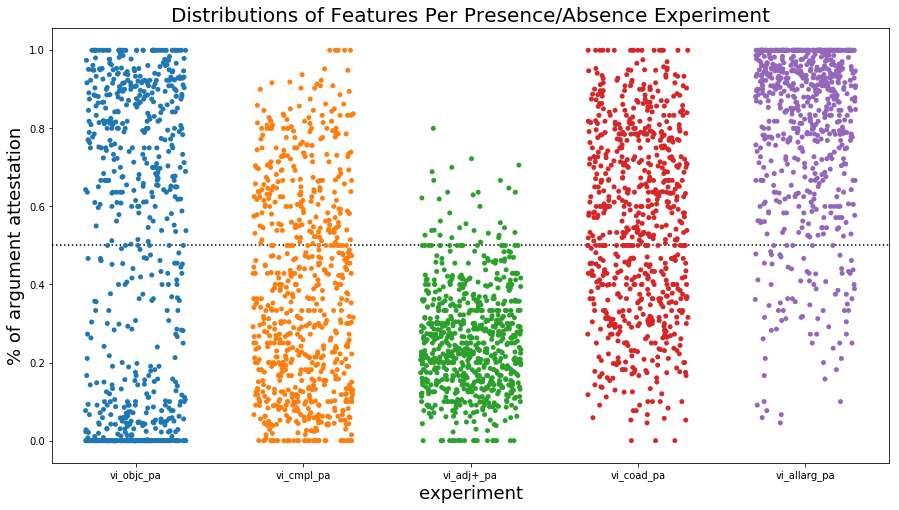

In [15]:
vi_datas = pd.DataFrame((experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()).loc['Objc']) # normalized objc data
vi_datas.columns = ('ratio of attestation',)
vi_datas['experiment'] = 'vi_objc_pa'

for exp_name, experiment in experiments.items():
    
    if exp_name == 'vi_objc_pa' or not re.match('vi_.*_pa', exp_name): # skip any non-pa experiments
        continue
        
    exp = experiment.data / experiment.data.sum() # normalize

    arg = next(i for i in exp.index if i != 'ø')
    
    datas = pd.DataFrame(exp.loc[arg])
    datas.columns = ('ratio of attestation',)
    datas['experiment'] = exp_name
    
    vi_datas = pd.concat((vi_datas, datas))

plt.figure(figsize=(15,8))
plt.title('Distributions of Features Per Presence/Absence Experiment', fontsize=20)
sns.stripplot(x='experiment', y='ratio of attestation', data=vi_datas, jitter=0.3)
plt.xlabel('experiment', fontsize=18)
plt.ylabel('% of argument attestation', fontsize=18)
plt.axhline(0.5, color='black', linestyle='dotted')

Points on the graph are individual verbs, for each of which we look at the percentage of its overall uses with the argument in question (e.g. the blue points show how often verbs occur with an object).

### Initial Observations

The combined, complement + adjunct experiment seems to have the most even distribution of features. The object presence/absence experiment appears to show the most separation between verbs. The adjunct tends to have <50% attestation, while the opposite is true for the allarg experiment.

It is possible to venture a few generalizations based on this visual:

* Verbs appear to exhibit a more even polarity between the presence/absence of an object argument.
* The number of verbs that occur with or without a complementizer appear to be fairly balanced, with a slight preference for <50% of those verbs' occurrences having a complement.
* There are more verbs with ≤50% of adjunct elements.
* The number of verbs with a higher proportion of complement or adjunct arguments is seems evenly distributed, with a slight preference for >50%.
* The number of verbs with a proportion >50% of any of the arguments appears to be high. 

#### Number of Verbs with 100% or 0% Objc

In [16]:
ratioedO = experiments['vi_objc_pa'].data / experiments['vi_objc_pa'].data.sum()
allO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] == 1.0]
noO = ratioedO.loc['Objc'][ratioedO.loc['ø'] == 1.0]

print(f'{allO.shape[0]} verbs that have an object 100% of the time...')
print(f'{noO.shape[0]} verbs that never occur with an object...')

39 verbs that have an object 100% of the time...
148 verbs that never occur with an object...


#####  Verbs with 100% Objects

In [17]:
#print(' | '.join(allO.index))

##### Verbs with 0% Objects

In [18]:
#print(' | '.join(noO.index))

In [19]:
# B.show(B.search('''

# clause
#     phrase function=Pred
#         word lex=BW>[ vs=qal

#     phrase function=Objc
# '''))

BW> with objects is a good example of the shortcomings of the ETCBC "object" label, which does not sharply distinguish between "objects" and "complements." Note however the group of verbs just beneath the 20% marker in the strip chart. Are many of these motion verbs like BW>?

In [20]:
smallO = ratioedO.loc['Objc'][ratioedO.loc['Objc'] <= 0.20]
print(f'{smallO.shape[0]} verbs that have an object ≤20% of the time...')

289 verbs that have an object ≤20% of the time...


In [21]:
#print(' | '.join(smallO.index))

## Preparing for Similarity Analysis

For each specimen, calculate its similarity with all other specimens pairwise based on all experiments which they have in common. The similarity scores will be averaged across all of the shared experiments. All raw counts have been adjusted using the pointwise mutual information (pmi) score. Counts for 

### Averaged Similarity Scores

Average similarities across all experiments to derive a list of test cases.

In [22]:
sim_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for pairwise similarities
common_matrix = pd.DataFrame(np.zeros(shape=(len(specimens), len(specimens))), columns=specimens, index=specimens) # for counting number of common experiments

for lex in specimens:
    for space_name, space in spaces.items():
        
        sim_measure = eval(f'space.{countType[space_name]}')
        
        if lex not in sim_measure.columns:
            continue
        
        sim_matrix[lex] = sim_matrix[lex].add(sim_measure[lex], fill_value=0)
        common_matrix[lex] += 1
        
sim = sim_matrix / common_matrix

In [23]:
#list(sim.columns)

In [24]:
sim['PYH[.qal']['PTX[.qal'] # random test

0.6039677227292085

In [25]:
sim['HJH[.qal'].sort_values(ascending=False).head(10)

<FH[.qal    0.464889
NTN[.qal    0.462615
BW>[.qal    0.418550
QR>[.qal    0.407704
JY>[.qal    0.397450
HLK[.qal    0.386329
R>H[.qal    0.384985
<BR[.qal    0.383098
JCB[.qal    0.376593
LQX[.qal    0.376241
Name: HJH[.qal, dtype: float64

In [26]:
sim['NTN[.qal'].sort_values(ascending=False).head(10)

FJM[.qal    0.531110
<FH[.qal    0.511623
BW>[.hif    0.489609
LQX[.qal    0.471965
HJH[.qal    0.462615
NF>[.qal    0.429783
QR>[.qal    0.423776
CWB[.hif    0.412513
CLX[.qal    0.404346
BNH[.qal    0.396383
Name: NTN[.qal, dtype: float64

### Looking at Surprise Word Similarities

One of the major goals of this project is to determine how verb meanings and classes are naturally distinguished by their context. היה is an interesting case of a verb which likely has no exact synonyms, but which exhibits similarity across all averaged experiments with words that are seemingly unsimilar such as נתן, עשה, בוא, etc. (see above). The purpose of gathering various kinds of contexts via the experiment parameters is to discover which contexts in particular are similar or different in various kinds of verbs. 

### Deriving Plot Arrangements for Similarity Analysis

The arrangment of experiment parameters on the plot is important, since I hope to use it to identify patterns. So here I develop an ordering and color scheme to be used with all of the plots.

##### Concept: Develop an ordering scheme based on specificity of parameters
I can attempt to arrange elements from more to less specific parameters. An example of a "specific" parameter would be one with lexical arguments, while a "general" parameter might only count the presence or absence of a given argument. Below is a concept of priorities:

1. verb grammar (vg)
    1. verb tense
2. verb domain (vd)
    1. simple domain
    2. embedded domain
    3. context clause chain
    4. context clause
    5. parallelism
    6. context window
3. verb inventories (allargs, adjunct, complement, object)
    1. presence
    2. animacy
    3. domain
    4. lexemes
4. verb frames
    1. same order as verb inventories

In [47]:
# make bar orders and map to colors

verb_grammar = ['vg_tense']

verb_domain = '''
vd_domain_simple
vd_domain_embed
vd_con_chain
vd_con_clause
vd_con_window
vd_par_lex
'''.strip().split('\n')

vi_pa = '''
vi_allarg_pa
vi_coad_pa
vi_adj+_pa
vi_cmpl_pa
vi_objc_pa
'''.strip().split('\n')

vi_animacy = '''
vi_subj_animacy
vi_allarg_animacy
vi_coad_animacy
vi_adj+_animacy
vi_cmpl_animacy
vi_objc_animacy
'''.strip().split('\n')

vi_domain = '''
vi_subj_domain
vi_allarg_domain
vi_coad_domain
vi_adj+_domain
vi_cmpl_domain
vi_objc_domain
'''.strip().split('\n')

vi_lex = '''
vi_allarg_lex
vi_coad_lex
vi_subj_lex
vi_adj+_lex
vi_cmpl_lex
vi_objc_lex
'''.strip().split('\n')

vf_pa = '''
vf_argAll_pa
vf_coad_pa
vf_adju_pa
vf_cmpl_pa
vf_obj_pa
'''.strip().split('\n')

vf_animacy = '''
vf_argAll_animacy
vf_coad_animacy
vf_adju_animacy
vf_cmpl_animacy
vf_obj_animacy
'''.strip().split('\n')

vf_domain = '''
vf_argAll_domain
vf_coad_domain
vf_adju_domain
vf_cmpl_domain
vf_obj_domain
'''.strip().split('\n')

vf_lex = '''
vf_argAll_lex
vf_coad_lex
vf_adju_lex
vf_cmpl_lex
vf_obj_lex
'''.strip().split('\n')

blues = sns.color_palette(palette='Blues')
reds = sns.color_palette(palette='Reds')

# map experiment groups to colors
color2experiment = (('gold', verb_grammar),
                    ('purple', verb_domain),
                    (blues[1], vi_pa),
                    (blues[2], vi_animacy),
                    (blues[4], vi_domain),
                    (blues[5], vi_lex),
                    (reds[1], vf_pa),
                    (reds[2], vf_animacy),
                    (reds[4], vf_domain),
                    (reds[5], vf_lex))

# make ordered tuple of colors
expcolors = tuple((exp, color) for color, exp_list in color2experiment # make tuple of colors
                        for exp in exp_list) 

**Below I prepare visualizer functions for examining similarities and differences in similarity scores.**

In [48]:
def get_sim_experiments(lex1, lex2, expcolors=expcolors, show=True, returnData=True, wordSet=None):
    '''
    Exports a barchart that illustrates the level
    of similarity between two lexemes per all experiments
    in the dataset.
    '''
    
    sims = dict() # temporarily hold similarity scores here
    
    # gather rated similarities between the two terms for every provided experiment
    for sp_name, space in spaces.items():
        
        sim_measure = eval(f'space.{countType[sp_name]}')
        wordSet = wordSet or {lex1, lex2}

        if wordSet & set(sim_measure.columns) != wordSet: # ensure both terms are in the space
            continue
            
        sims[sp_name] = sim_measure[lex1][lex2] # get similarity
        
    sims_ordered = collections.OrderedDict((exp[0], sims[exp[0]]) for exp in expcolors if exp[0] in sims) # customized order
    sims = pd.DataFrame(list(sims_ordered.items())) # drop into Dataframe
    sims.columns = ['experiment', 'score'] # set col names
    
    if show:
        # plot:
        colors = tuple(expcol[1] for expcol in expcolors if expcol[0] in sims['experiment'].values)        
        plt.figure(figsize=(18, 8)) 
        sns.barplot(sims['experiment'], sims['score'], palette=colors, orient='v')
        plt.xticks(rotation='vertical', fontsize=12)
        plt.xlabel('experiment', fontsize=18)
        plt.ylabel('similarity score', fontsize=18)
        plt.title(f'Scored Similarities between {lex1} and {lex2}', fontsize=20)
        
    if returnData:
        return sims
    
def compare_simPatterns(dataset1, dataset2, pairs='', colors=expcolors):
    '''
    Compare barchart similarity patterns accross two barcharts.
    The first dataset is the primary dataset and will be colored
    normally. The second dataset will be colored grey for comparison.
    '''
    
    data1Sims = list(reversed(dataset1['score']))
    data2Sims = list(reversed(dataset2['score']))
    xLocations = np.arange(dataset1.shape[0])
    barwidth = 0.8       # the width of the bars: can also be len(x) sequence
    plt.figure(figsize=(10, 15)) 
    p1 = plt.barh(xLocations, data1Sims, barwidth, color=sns.color_palette(palette='Reds')[3])
    p2 = plt.barh(xLocations, data2Sims, barwidth, color=sns.color_palette(palette='Blues')[4])
    plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
    
    plt.ylabel('experiment', fontsize=18)
    plt.xlabel('similarity score', fontsize=18)
    plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)
    
    plt.legend((p1[0], p2[0]), (f'{pairs[0]}', f'{pairs[1]}'), fontsize=12)
    
def compareSets(set1, set2):
    '''
    Compare two pairs of words and their similarity differences.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    
    compare_simPatterns(dataset1, dataset2, pairs=(f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'))
    
def compareChange(set1, set2):
    '''
    Compare two pairs of words and plot the positive or negative
    difference in similarities from set1 to set2.
    '''
    dataset1 = get_sim_experiments(set1[0], set1[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    dataset2 = get_sim_experiments(set2[0], set2[1], show=False, wordSet={set1[0], set1[1], set2[0], set2[1]})
    
    change = dataset1.copy() 
    change['score'] = change['score'] - dataset2['score']
    change['score'] = change['score'] / dataset1['score']
    
    datachange = list(reversed(change['score']))
    blue = sns.color_palette(palette='Blues')[3]
    red = sns.color_palette(palette='Reds')[4]
    colors = [blue if score > 0 else red for score in datachange]
    
    pairs = f'{set1[0]} & {set1[1]}', f'{set2[0]} & {set2[1]}'
    
    xLocations = np.arange(change.shape[0])
    barwidth = 0.8       # the width of the bars: can also be len(x) sequence
    plt.figure(figsize=(10, 15)) 
    plt.barh(xLocations, datachange, barwidth, color=colors)
    plt.yticks(xLocations, list(reversed(dataset1['experiment'])), fontsize=12)
    plt.ylabel('experiment', fontsize=18)
    plt.xlabel('ratio of similarity score difference', fontsize=18)
    plt.title(f'Similarity Differences between {pairs[0]} and {pairs[1]}', fontsize=20)

## Similarity Analyses

We will analyze the top ten words ranked by frequency of experiment data counts. For each word we look at the top 5 most similarly ranked words and analyze two categories: intuitive matches and surprising matches. Intuitive matches are those for which we can recognize a valid (as humanly judged) semantic similarity. We visualize the specific scores of similarity per experiment with barcharts. The charts allow us to map specific areas of similarity and dissimilarity based on the test parameters of the experiments. In doing so, we explore how similarity is multifaceted and whether there are any perceptible differences in intuitively and surprisingly matched terms. Another barchart is used to show differences between intuitively matched terms and surprisingly matched terms. This helps to isolate which experiment parameters consistently yield differences between intuitive and surprising matches.

### Deriving a Case Study Set

Further above we have generated a frequency count for each lexeme in the specimen set. This allows us to select the top most common lexemes for the case study as shown below.

In [49]:
freq_count.most_common(10)

[('>MR[.qal', 47974.0),
 ('HJH[.qal', 34658.0),
 ('<FH[.qal', 22837.0),
 ('BW>[.qal', 19062.0),
 ('NTN[.qal', 18194.0),
 ('HLK[.qal', 13360.0),
 ('R>H[.qal', 10784.0),
 ('DBR[.piel', 10002.0),
 ('CM<[.qal', 9999.0),
 ('LQX[.qal', 9136.0)]

We can create a loose list of groups for these lexemes based on perceived intuitive similarities. These groups only serve the purpose of getting a sense of the lexical variety reflected in the most common set, and thus they do not go towards the analysis itself.

In this top ten set, we can see six general groups of verbs:

1. **communication** - >MR[.qal, DBR[.piel
2. **state** - HJH[.qal
3. **doing/making** - <FH[.qal
4. **moving** - BW>[.qal, HLK[.qal
5. **manipulating** - NTN[.qal, LQX[.qal
6. **perceiving** - R>H[.qal, CM>.qal

There is good variety in this top 10 set. We begin with these top ten, to analyze their top-rated most-similar terms, and to compare surprising similarities against intuitive ones.

### אמר.qal

We begin the word-by-word evaluation with אמר ("to say"). The top five most similar terms are based on the average of similarity scores across all available experiments for אמר. They are listed below along with the averaged similarity score.

Similarity Scores with >MR
 QR>[.qal     0.467979
DBR[.piel    0.447590
NGD[.hif     0.407319
CLX[.qal     0.399751
YWH[.piel    0.399160
Name: >MR[.qal, dtype: float64 



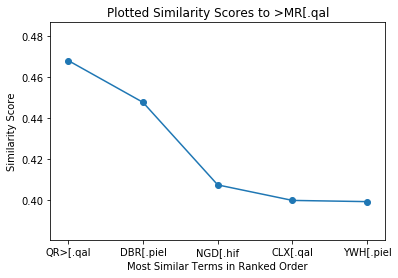

In [50]:
say_top_sim = sim['>MR[.qal'].sort_values(ascending=False).head(5) # get top 5 elements
plt.xticks(range(0, say_top_sim.shape[0]), say_top_sim.index)
plt.title('Plotted Similarity Scores to >MR[.qal')
plt.ylabel('Similarity Score')
plt.xlabel('Most Similar Terms in Ranked Order')
plt.scatter(range(0, say_top_sim.shape[0]), say_top_sim)
plt.plot(range(0, say_top_sim.shape[0]), say_top_sim)
print('Similarity Scores with >MR\n', say_top_sim, '\n')

קרא is ranked most similar at 0.47. דבר is close at 0.45. There is a 4 point decrease at the third ranked word, נגד, which the plot illustrates. At שלח and צוה there is a flattening in similarity decreases.

We can note that the first three terms are good intuitive matches. Of the last two, שלח and צוה, the latter seems intuitively more similar to שלח, since it is verbal communication like קרא and דבר. Is שלח included here because of its occasional use in messenger/communication situations, or for another reason? What is the precise nature of the similarity between these latter two terms, especially in comparison to the more intuitive matches? Are there any patterns that distinguish between שלח and צוה?

To answer these questions, we now turn to the analysis and comparison of similarity scores across the experiments.

#### Similarity Patterns for Intuitive Matches to אמר

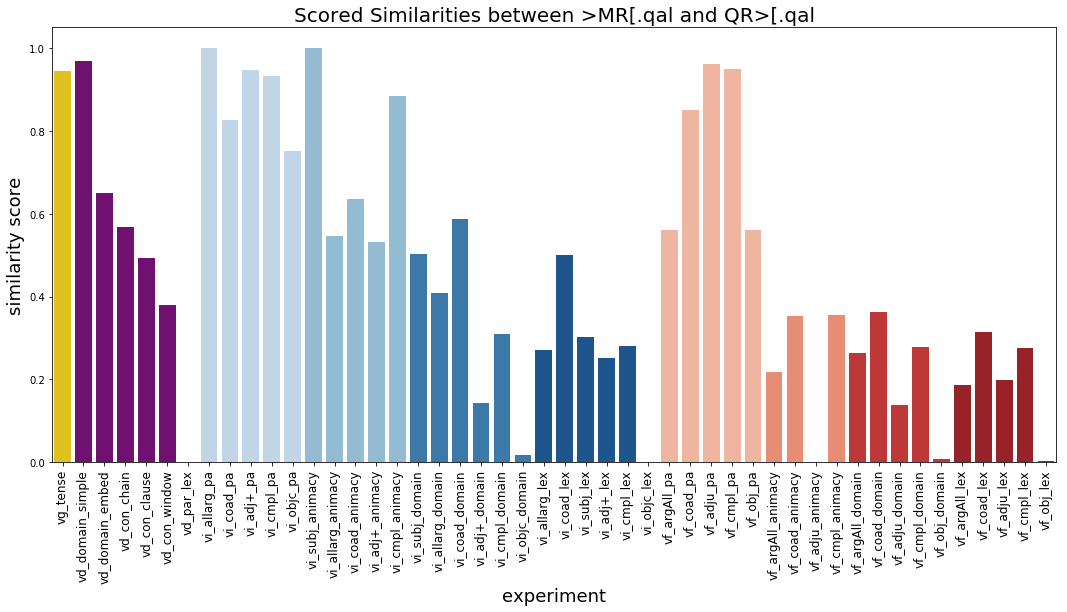

In [51]:
say_call = get_sim_experiments('>MR[.qal', 'QR>[.qal')

Each score has been normalized according to the maximum similarity value per experiment so that the scores are judged in relation to the experiment's performance overall. Still, some experiments consistently register lower similarity scores, probably due to greater diversity in potential variables. In many `pa` experiments, for instance, there are only two possible values, so similarity is likely to rank higher throughout those experiments.

Each color group represents a different experiment strategy while different shades represent different data points, with increasing darkness for increasing specificity of the experiments' datapoint. Thus, higher bars within darker shaded groups will presumably show more specific similarities.

Starting with the `vg` and `vd` experiments, we see a high degree of agreement in verb tense as well as simple domain. For the other `vd` experiments there is decreasing similarity as the specificity of the datapoint increases down to the context of a window. There does not appear to be any parallelism shared between אמר and קרא (`vd_par_lex`).

In the inventory `pa` experiments we see high levels of agreement across allarg, adj+, and cmpl experiments. There are slightly lower levels for the coad experiment, probably due to the even lower agreement found in `vi_objc_pa`.

We can see that אמר and קרא differ in their 



* high agreement across vi_allarg_pa, vi_adj+\_pa, and vi_cmpl_pa.
* high agreement in vf_coad_pa, vf_adju_pa, and vf_cmpl_pa
* high agreement in vi_cmpl_animacy
* high agreement in vi_subj_animacy
* Relatively large agreement in vf_coad_animacy and vf_cmpl_animacy'
* Comparatively lower agreement in object vi and vf experiments.

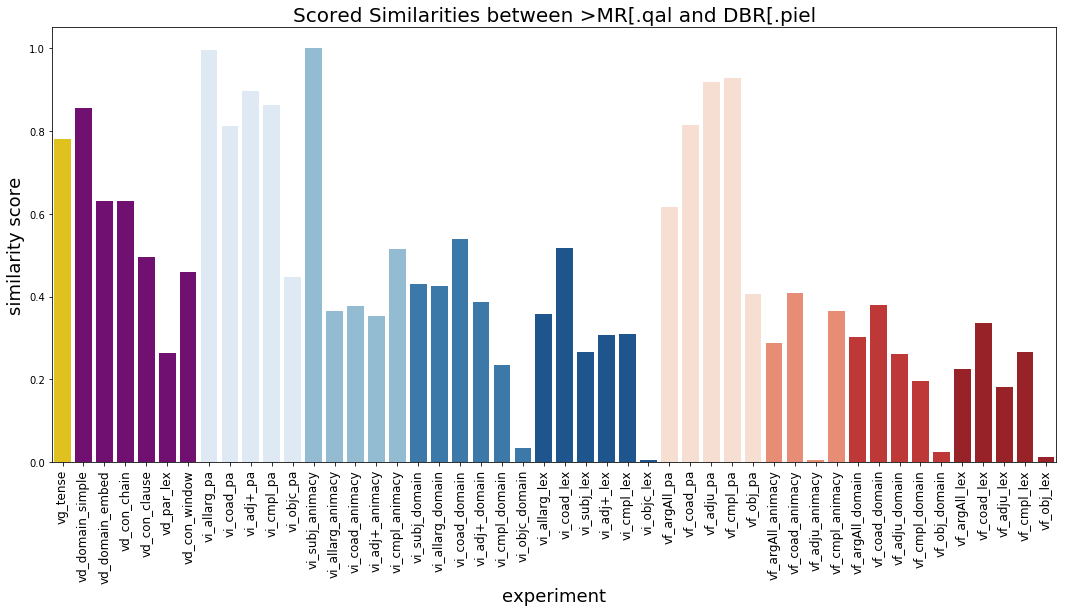

In [44]:
say_speak = get_sim_experiments('>MR[.qal', 'DBR[.piel')

##### Observations
* run of 5 across vi_pa experiments.
* high vi_subj_animacy
* Quite distinguished similarities in vf_cmpl_pa and vf_obj_pa
* Run of 3 across vf_argAll_pa, vf_coad_pa, and vf_adju_pa
* high vi_cmpl_animacy
* high parallelism agreement in comparison to קרא

In what ways do קרא and דבר differ in their similarity to אמר? We can visualize the differences by comparing the two levels of similarity:

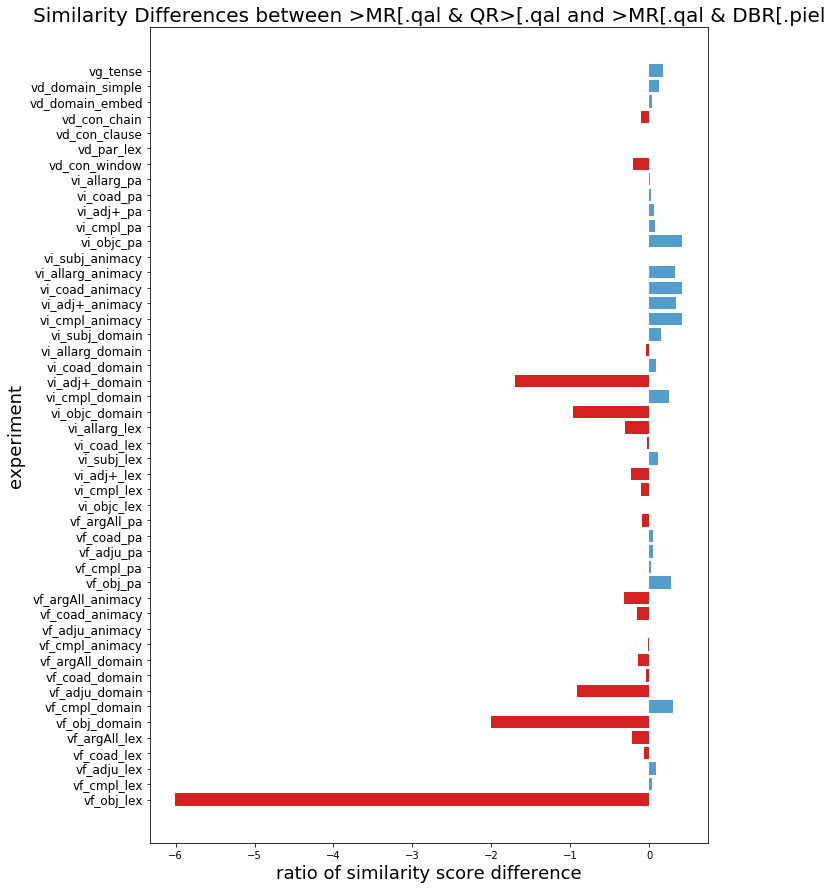

In [103]:
compareChange(('>MR[.qal', 'QR>[.qal'),('>MR[.qal', 'DBR[.piel'))

Here we see that דבר has advantages over 

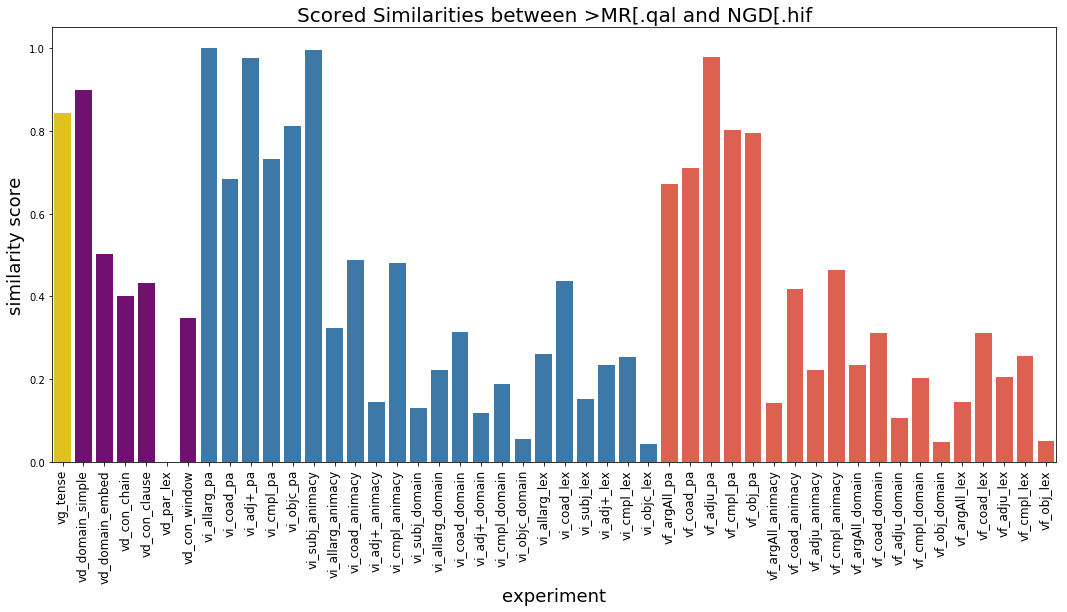

In [64]:
say_declare = get_sim_experiments('>MR[.qal', 'NGD[.hif')

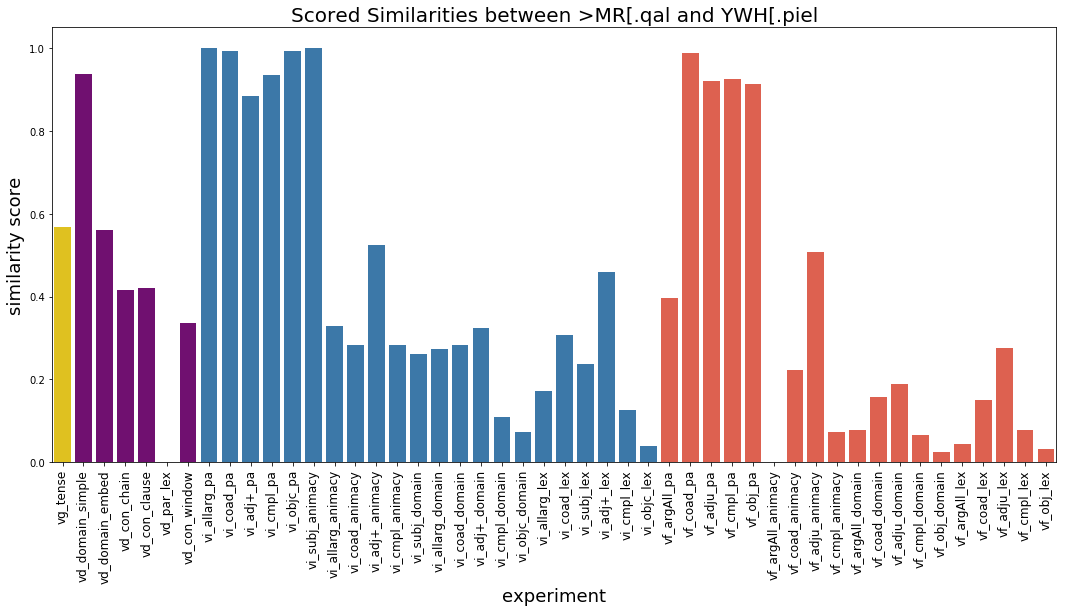

In [65]:
say_command = get_sim_experiments('>MR[.qal', 'YWH[.piel')

** >MR || CLX**

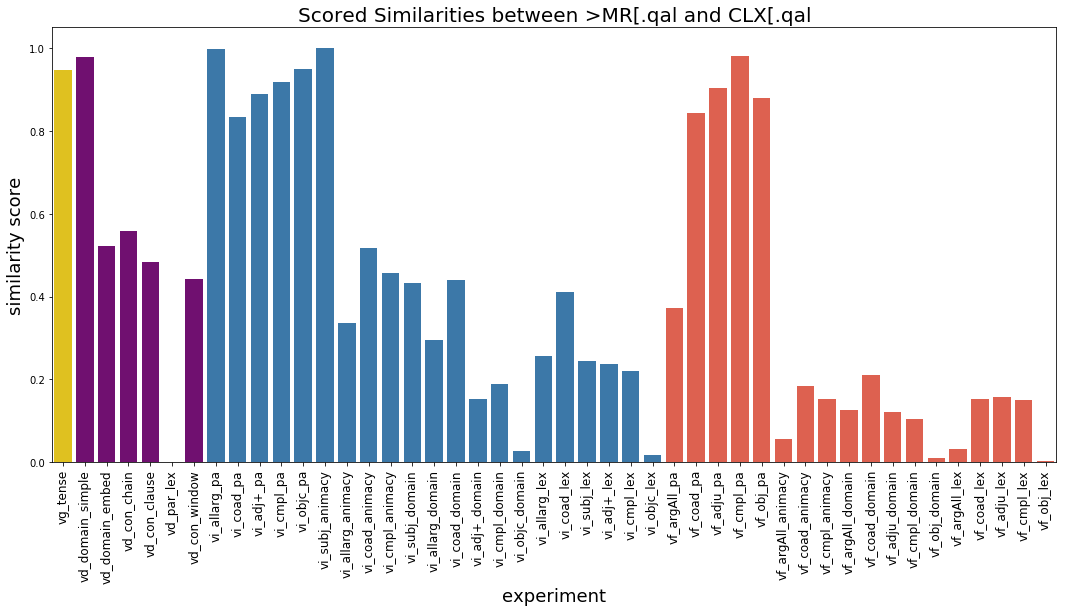

In [66]:
say_give = get_sim_experiments('>MR[.qal', 'CLX[.qal')

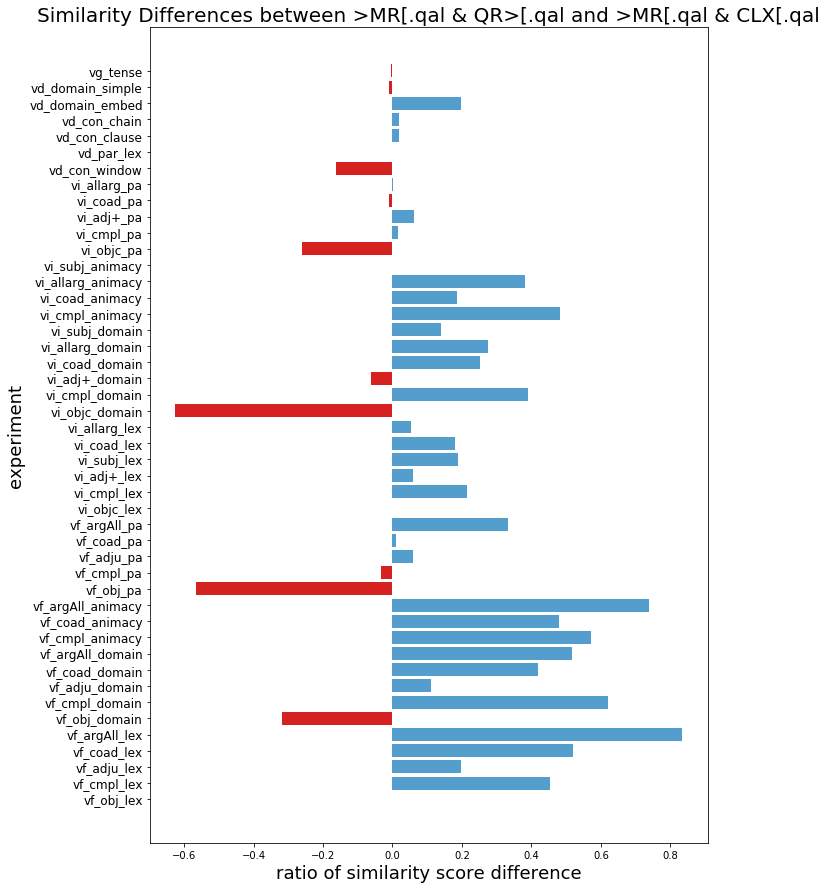

In [106]:
compareChange(('>MR[.qal', 'QR>[.qal'),('>MR[.qal', 'CLX[.qal'))

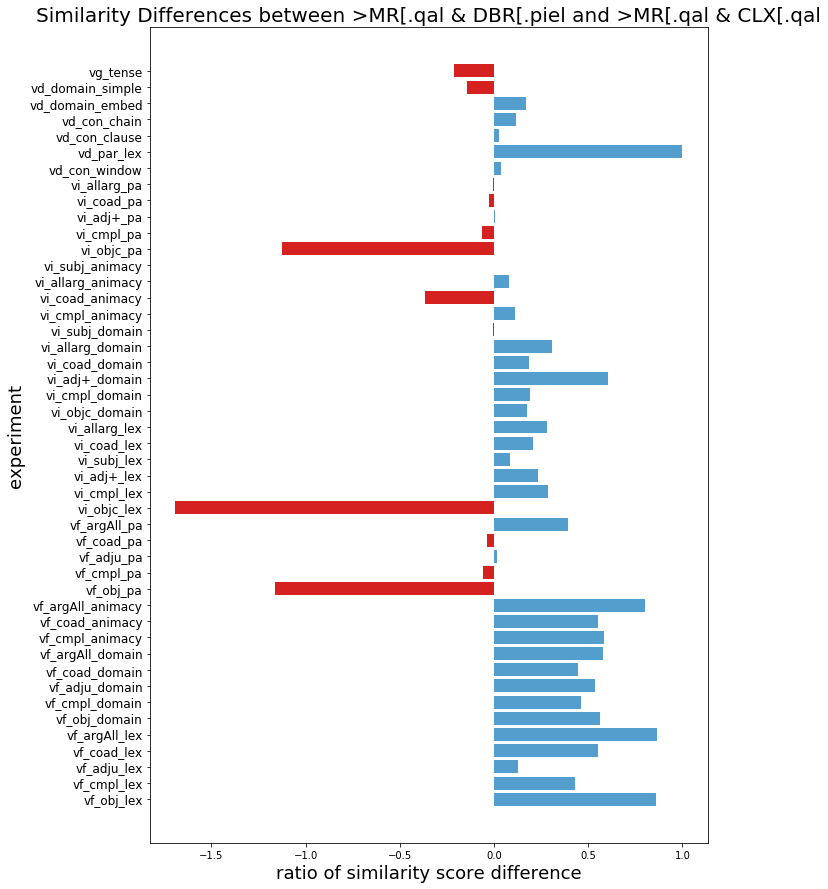

In [107]:
compareChange(('>MR[.qal', 'DBR[.piel'),('>MR[.qal', 'CLX[.qal'))

If we reverse the order and look at the difference in similarity the other direction there are major decreases in similarity across the board:

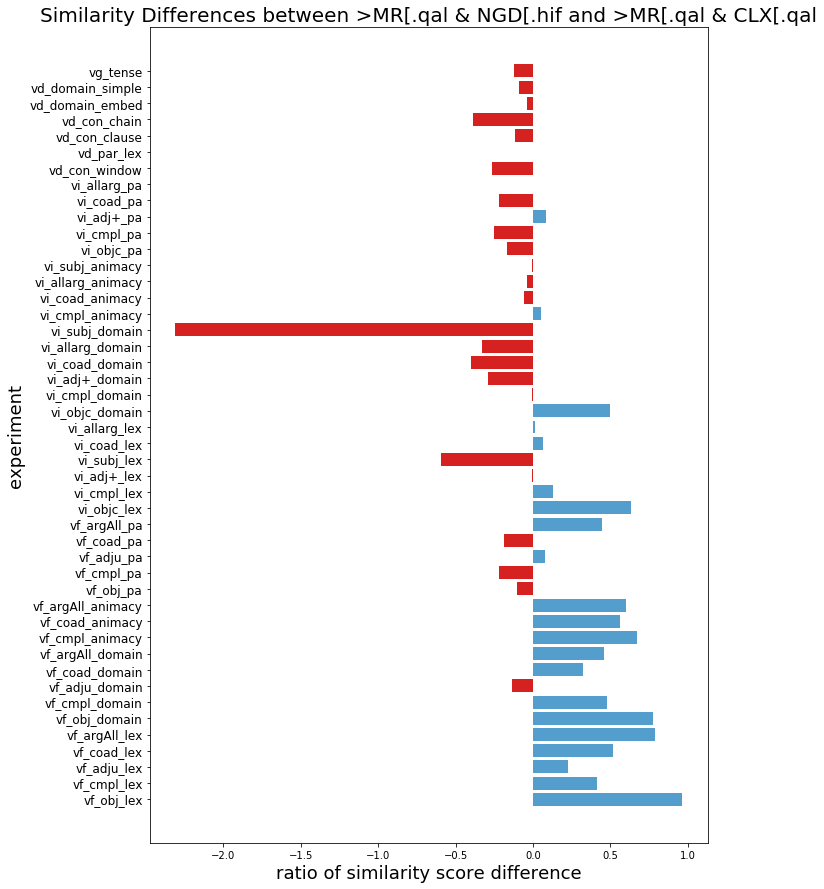

In [108]:
compareChange(('>MR[.qal', 'NGD[.hif'),('>MR[.qal', 'CLX[.qal'))

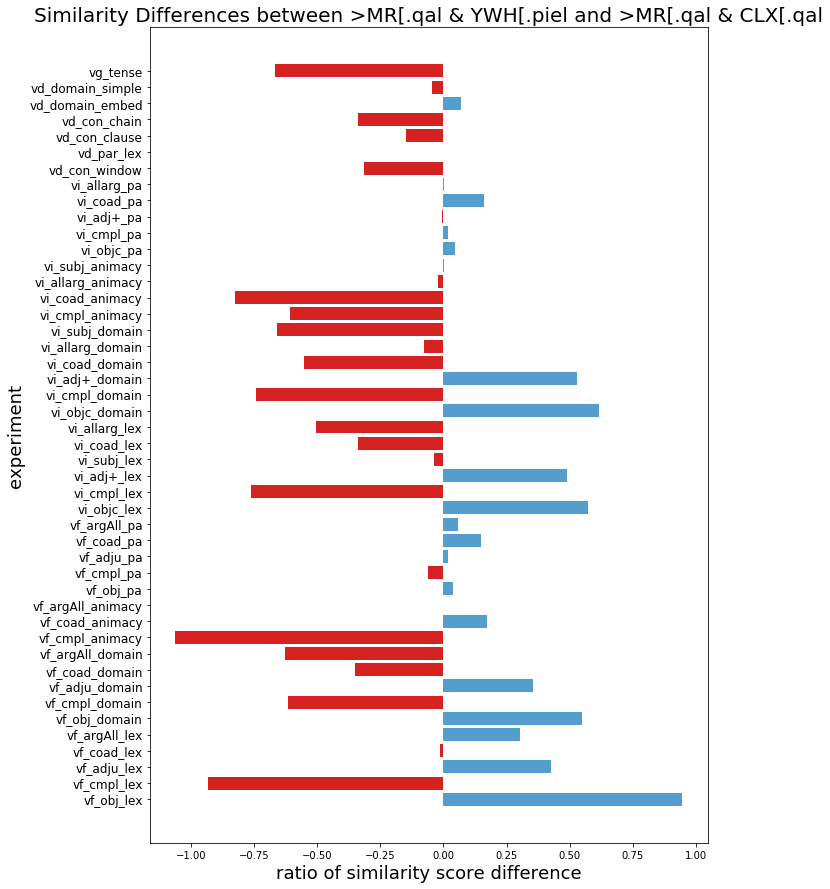

In [109]:
compareChange(('>MR[.qal', 'YWH[.piel'),('>MR[.qal', 'CLX[.qal'))

There seems to be a pattern emerging in that intuitive pairs frequently exhibit an increase in frame experiments across animacy, domain, and lex over against the surprising pairs. Note the blue increases above compared with the red decreases below in the inverse test. This same pattern can be seen in the former tests as well. At the same time, the inventory and domain experiements reflect slight increases from the perspective of the surprising set, as seen below.

#### Similarity Patterns for Unintuitive Matches

**>MR || <FH**

The sixth surprising match (not included above) is <FH. Can we also spot the differences there?

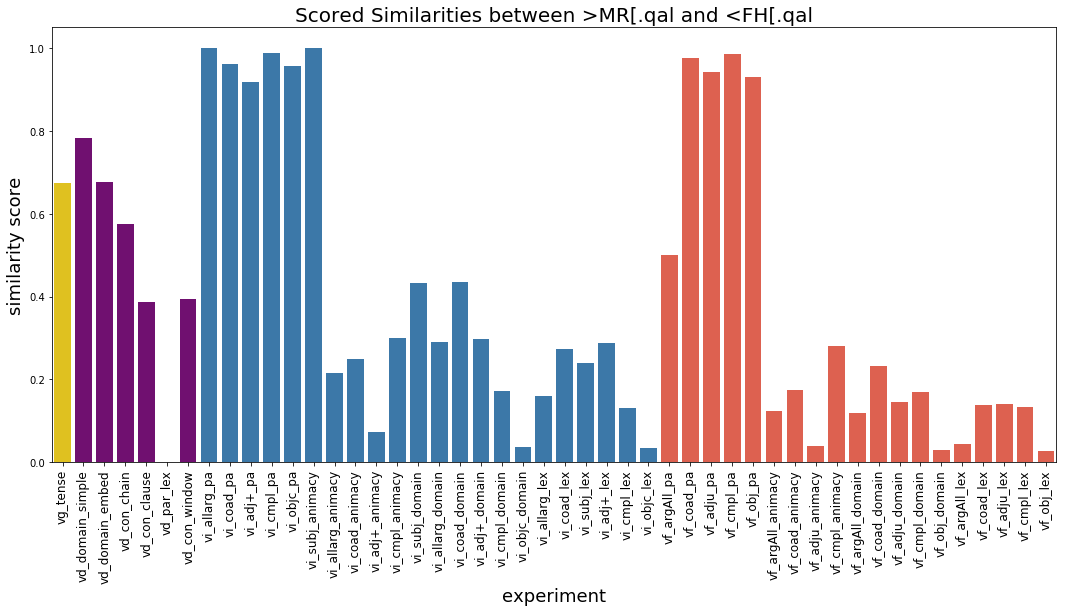

In [111]:
say_do = get_sim_experiments('>MR[.qal', '<FH[.qal')

##### Observations
* Run of 5 across the vi_pa experiments
* High vi_subj_animacy and vi_subj_domain
* High vf_cmpl_pa with corresponding high scores across vf_adju_pa, vf_obj_pa, and vf_coad_pa; though the last is noticeably lower. 

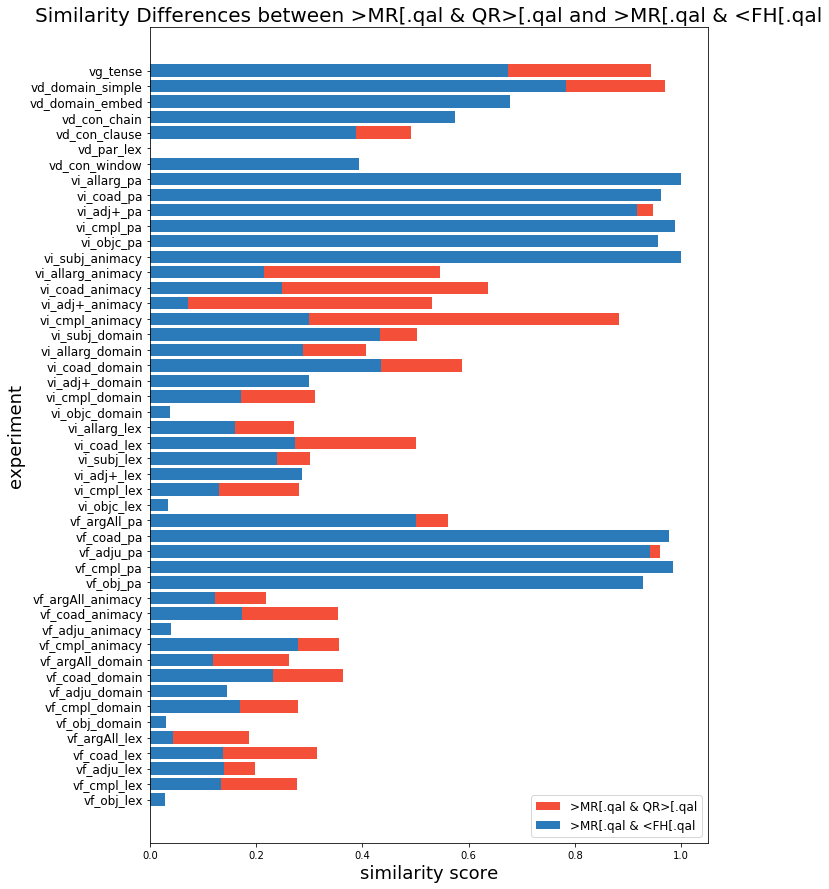

In [112]:
compareSets(('>MR[.qal', 'QR>[.qal'), ('>MR[.qal', '<FH[.qal'))

This chart allows us to compare directly the differences in similarity score between the two pairs. However, note that some changes, while not as big as others, are proportionately bigger than their original values. For instance, there is only an increase of ~0.2 in vf_coad_animacy. But overall this represents a 100% increase in relation to the total similarity score for vf_coad_animacy. We can better represent the significance of the differences by taking the ratio or percent of difference in relation to the similarity score, as `compareChange` below demonstrates.

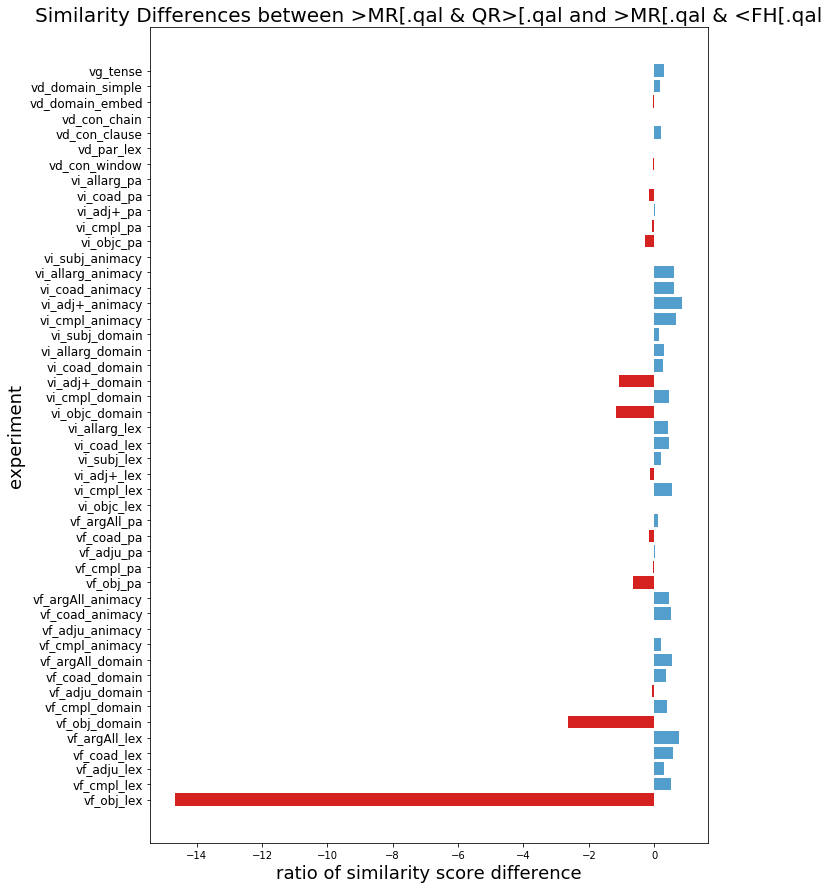

In [113]:
compareChange(('>MR[.qal', 'QR>[.qal'), ('>MR[.qal', '<FH[.qal'))

This chart shows the increases and decreases in similarity between the two pairs relative to the overall similarity score per experiment. To put it more simply, it shows the differences in similarity between >MR & QR> as compared with >MR & <FH. There are notable increases in similarity across the chart as a whole. But the most significant increases come in vi_adj+\_animacy (sixfold increase), and vf_argAll_lex. Othere increases are found in the complement and adjunct animacy experiments. 

There are notable decreases in similarity between several object experiments (vf_obj_domain, vf_obj_lex, vi_objc_domain, vi_objc_pa) as well as a sizeable decrease (-100%) in vf_adju_animacy.

What might be behind the high increase in similarity in the vf_allArg_lex experiment? We will gather the top common values between >MR and DBR. First, note how many dimensions this space consists of:

In [46]:
spaces['vf_argAll_lex'].pmi['>MR[.qal'].shape

(14761,)

The top similarities are found amongst the top 400 values between >MR and QR>.

In [47]:
# Top similarities between >MR and DBR

top_say = set(spaces['vf_argAll_lex'].pmi['>MR[.qal'].sort_values(ascending=False).head(400).index)
top_speak = set(spaces['vf_argAll_lex'].pmi['QR>[.qal'].sort_values(ascending=False).head(400).index)

top_say & top_speak

{'Adju.L_>MR[|Cmpl.>L_<M/',
 'Adju.L_>MR[|Cmpl.>L_>JC/',
 'Cmpl.>L_<BD/',
 'Cmpl.>L_<BDJHW/',
 'Cmpl.>L_>BCLWM/',
 'Cmpl.>L_CMW>L/',
 'Cmpl.>L_DWD==/',
 'Cmpl.>L_FR/',
 'Cmpl.>L_GJXZJ/',
 'Cmpl.>L_J<QB/',
 'Cmpl.>L_JFR>L/',
 'Cmpl.>L_JW>B/',
 'Cmpl.>L_LWV=/',
 'Cmpl.>L_MCH=/',
 'Cmpl.>L_MLK/',
 'Cmpl.>L_N<R/',
 'Cmpl.>L_YJB>/',
 'Cmpl.L_>BJTR/',
 'Cmpl.L_>BRM/',
 'Cmpl.L_>JC/',
 'Cmpl.L_CLMH=/',
 'Cmpl.L_CMCWN/',
 'Cmpl.L_HTK/',
 'Cmpl.L_J<QB/',
 'Cmpl.L_N<R/',
 'Cmpl.L_YDWQ/'}

Note such informative parallels as `Adju.L_>MR[|Cmpl.>L_<M/`, and instance shared by both >MR and QR> where L + >MR is used and directed towards the "people" (>L <M). The algorithm has thus found a key similarity between these two terms.

vi_adj+\_animacy showed the highest increase in similarity. Here are the arguments in common between >MR and QR> for that experiment:

In [48]:
top_say = set(spaces['vi_adj+_animacy'].pmi['>MR[.qal'].sort_values(ascending=False).head(10).index) # top 10
top_speak = set(spaces['vi_adj+_animacy'].pmi['QR>[.qal'].sort_values(ascending=False).head(10).index) # top 10

top_say & top_speak

{'<L_inanimate', '>L_animate'}

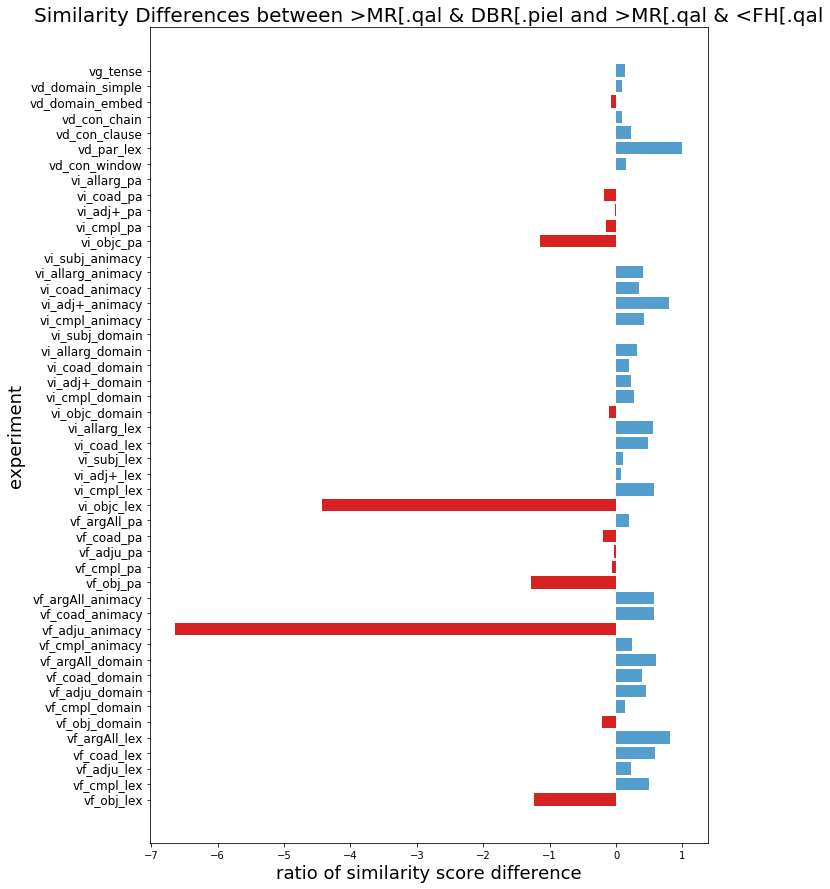

In [114]:
compareChange(('>MR[.qal', 'DBR[.piel'), ('>MR[.qal', '<FH[.qal'))

#### Observations

The two highest changes are found in vi_adj+\_animacy and vf_argAll_lex experiments, similar to what was observed between the last pair. Decreases happen in object experiments and the vf_adju_animacy experiment.

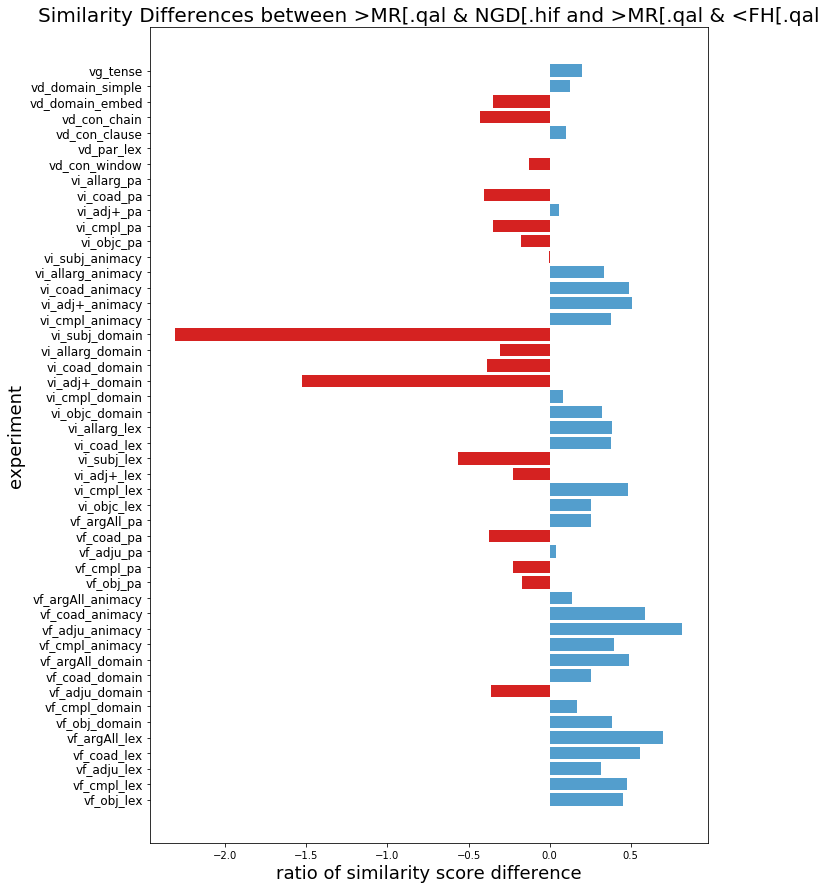

In [115]:
compareChange(('>MR[.qal', 'NGD[.hif'), ('>MR[.qal', '<FH[.qal'))

##### Observations

The biggest increase is in vf_adju_animacy rather than vi_adj+\_animacy, though the latter does see ~%100 increase. vf_argaAll_lex also has a significant increase. 

There are a number of noteworthy decreases across inventory domain experiments.

### היה.qal

In [116]:
sim['HJH[.qal'].sort_values(ascending=False).head(5)

<FH[.qal    0.464889
NTN[.qal    0.462615
BW>[.qal    0.418550
QR>[.qal    0.407704
JY>[.qal    0.397450
Name: HJH[.qal, dtype: float64

All of the similar terms are surprising for this verb. There is thus the added difficulty here that there is no apparent intuitively similar term to test the surprising occurrences against. Across the first two verbs, though, some indicators are visible. In its comparisons with NTN and <FH the verb HJH rates low for experiments that test for objects. This can be seen for the comparisons with <FH and NTN:

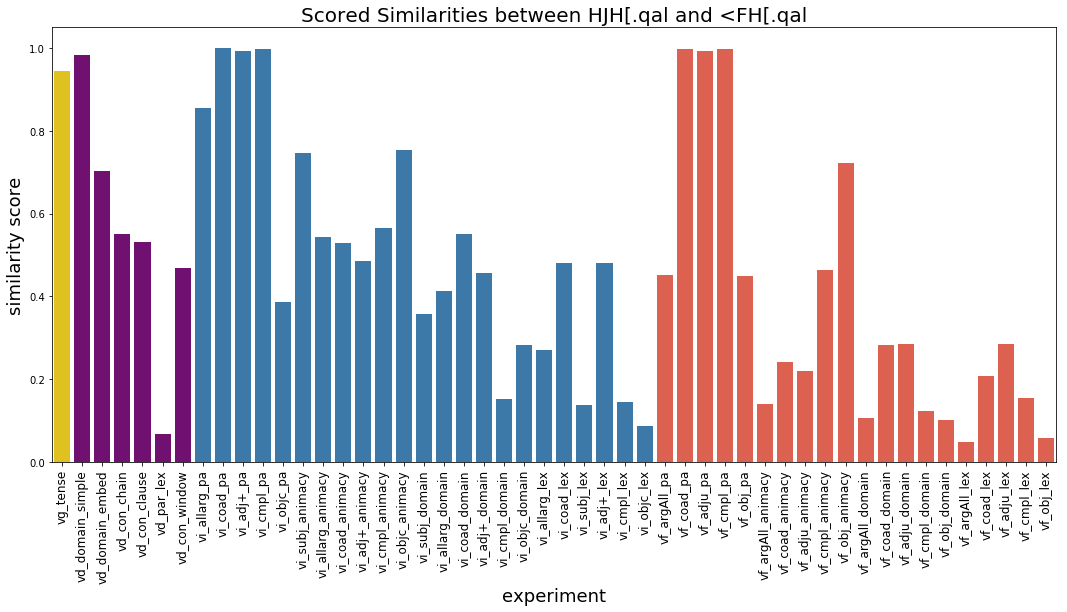

In [117]:
be_do = get_sim_experiments('HJH[.qal', '<FH[.qal')

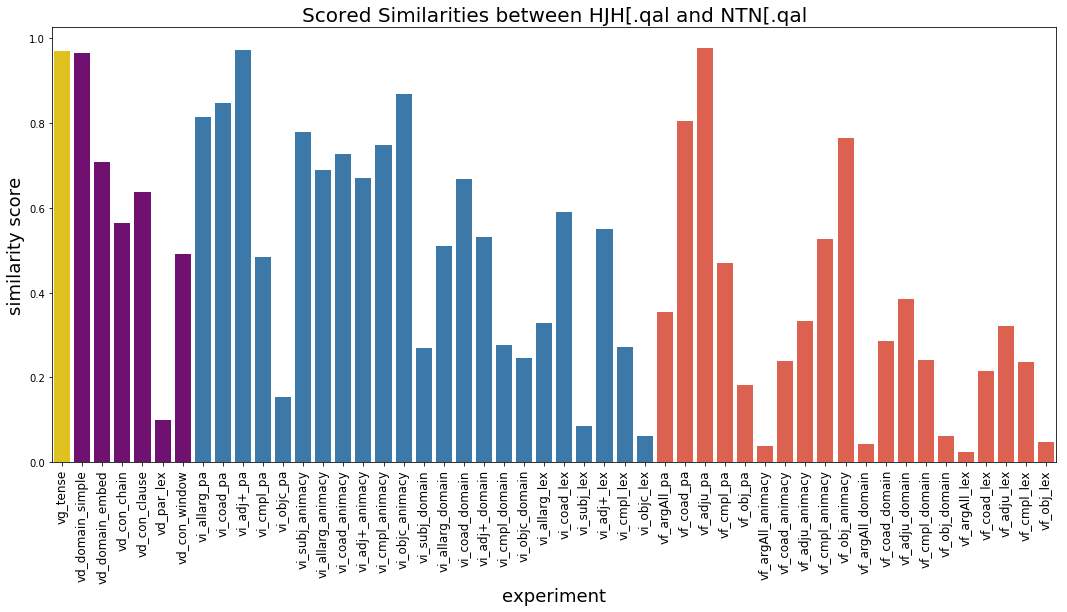

In [118]:
be_give = get_sim_experiments('HJH[.qal', 'NTN[.qal')

By comparison to the above examples, there is a significant *increase* in similarity for the object pa experiments for the remaining three verbs of movement. What is interesting about this similarity is that היה is proposed to have a sense of movement in terms of "falling" (BDB 224). 

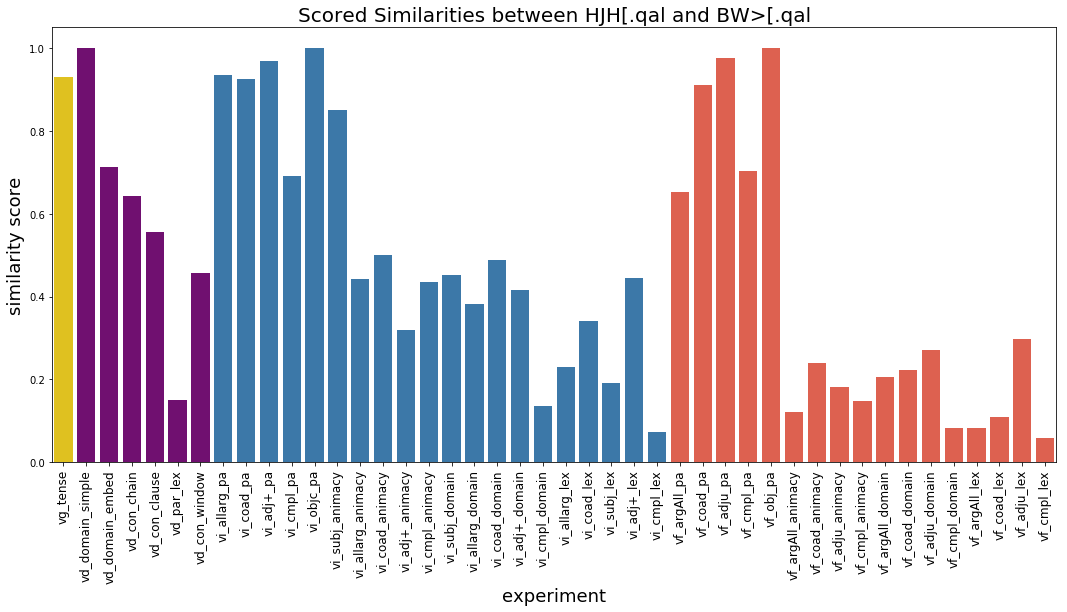

In [119]:
be_come = get_sim_experiments('HJH[.qal', 'BW>[.qal')

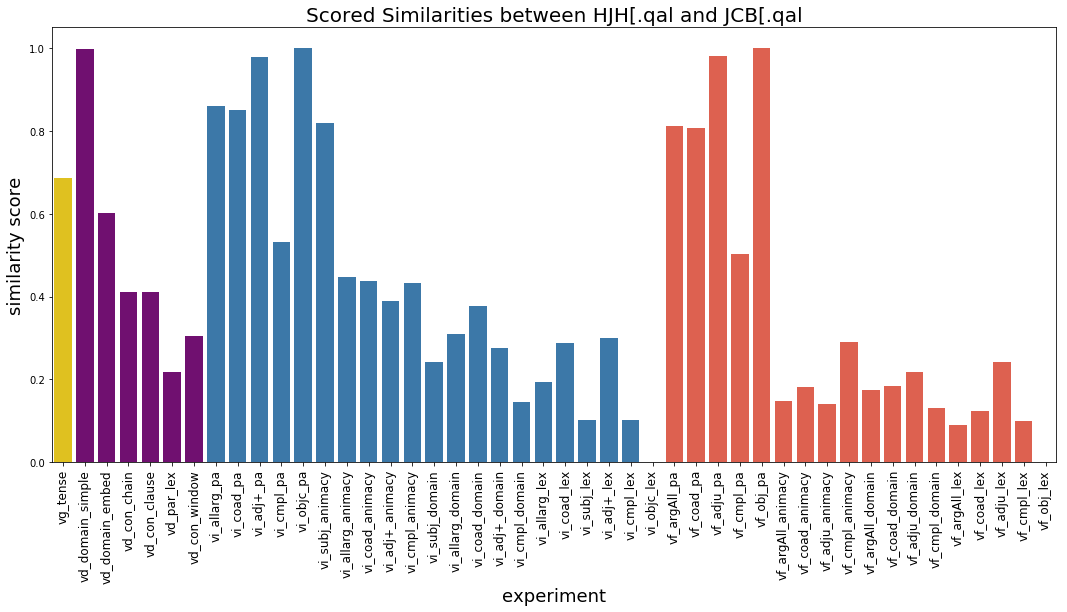

In [120]:
be_sit = get_sim_experiments('HJH[.qal', 'JCB[.qal')

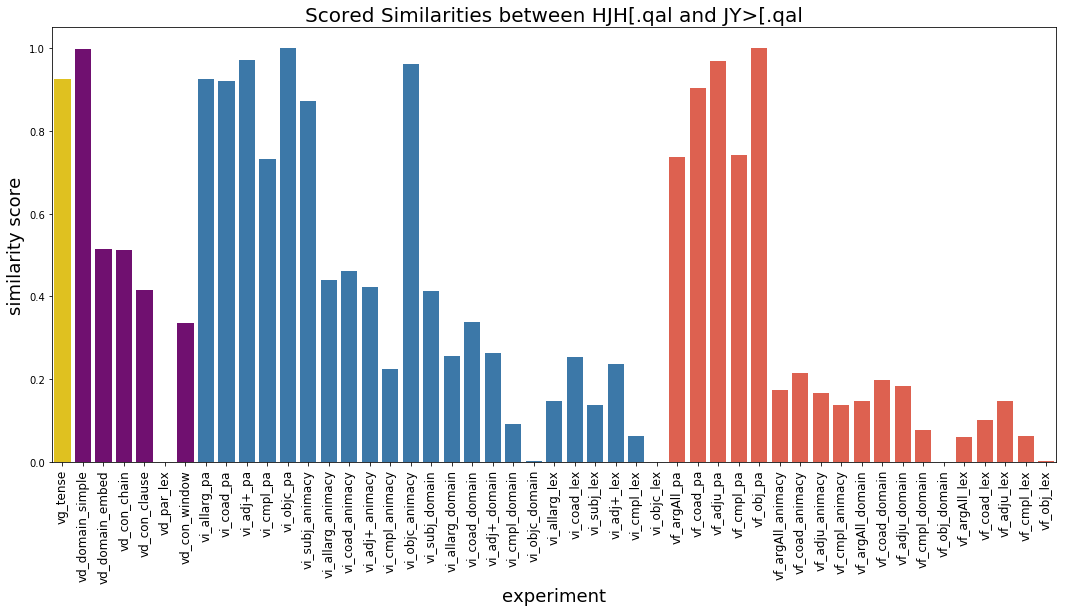

In [121]:
be_goout = get_sim_experiments('HJH[.qal', 'JY>[.qal')

Because there are no apparently intuitive verbs to compare against, the analysis of the HJH will need to await the analysis of the remaining verb forms. This way, we can use the knowledge gained from analysis of those verbs to understand the similarities with HJH better.

### נתן.qal

In [122]:
print('Similarity scores for NTN:')
sim['NTN[.qal'].sort_values(ascending=False).head(5)

Similarity scores for NTN:


FJM[.qal    0.531110
<FH[.qal    0.511623
BW>[.hif    0.489609
LQX[.qal    0.471965
HJH[.qal    0.462615
Name: NTN[.qal, dtype: float64

There are three terms which are intuitively similar and two which are not:
* Intuitive: FJM[.qal, BW>[.hif, LQX[.qal (antonym)
* Surprising: <FH[.qal, HJH[.qal

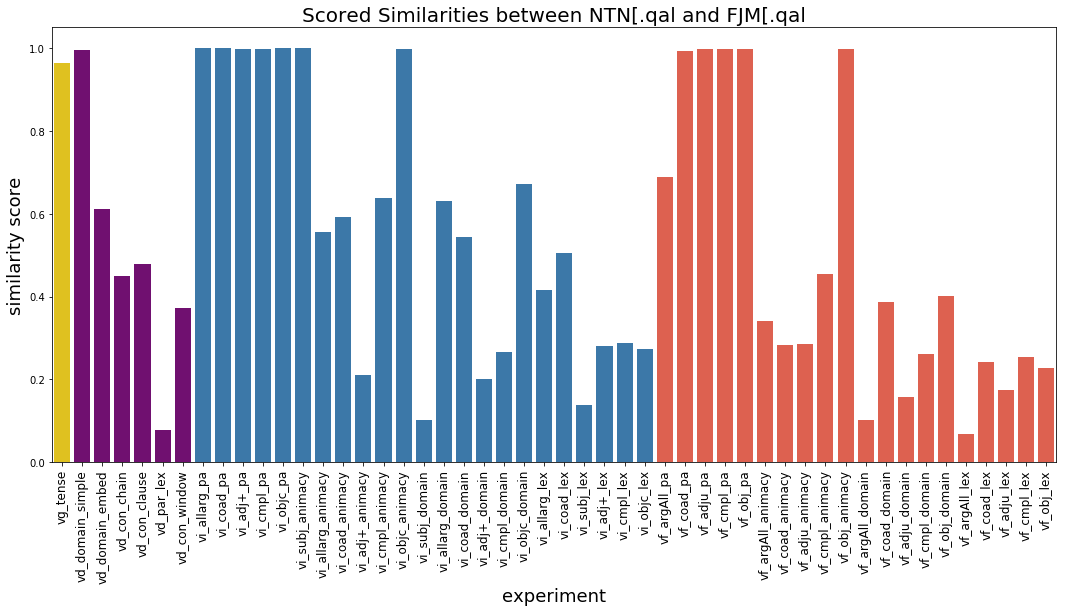

In [123]:
give_set = get_sim_experiments('NTN[.qal', 'FJM[.qal')

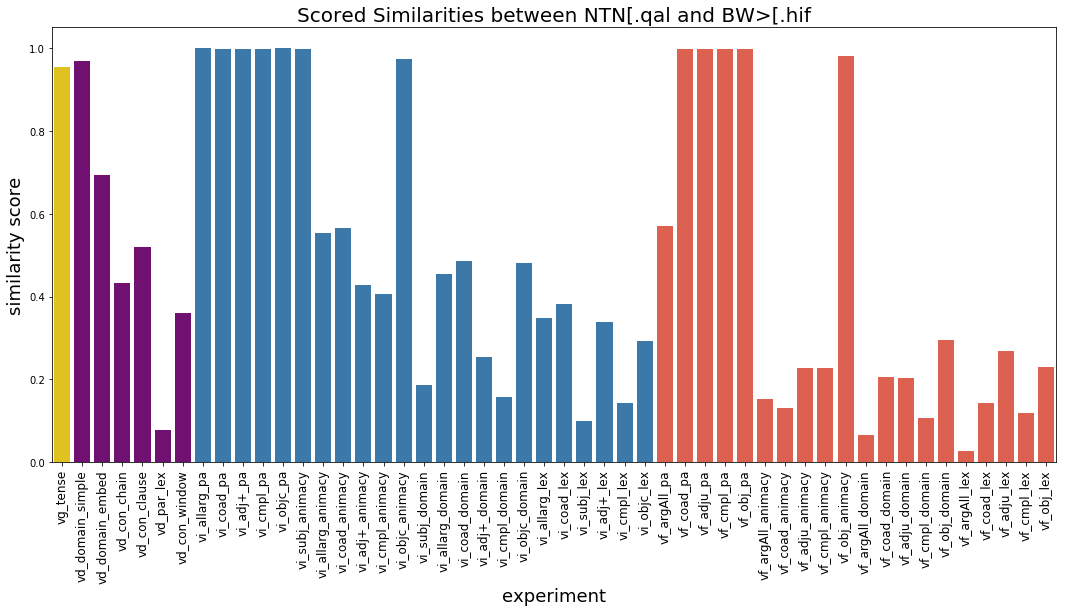

In [124]:
give_move = get_sim_experiments('NTN[.qal', 'BW>[.hif')

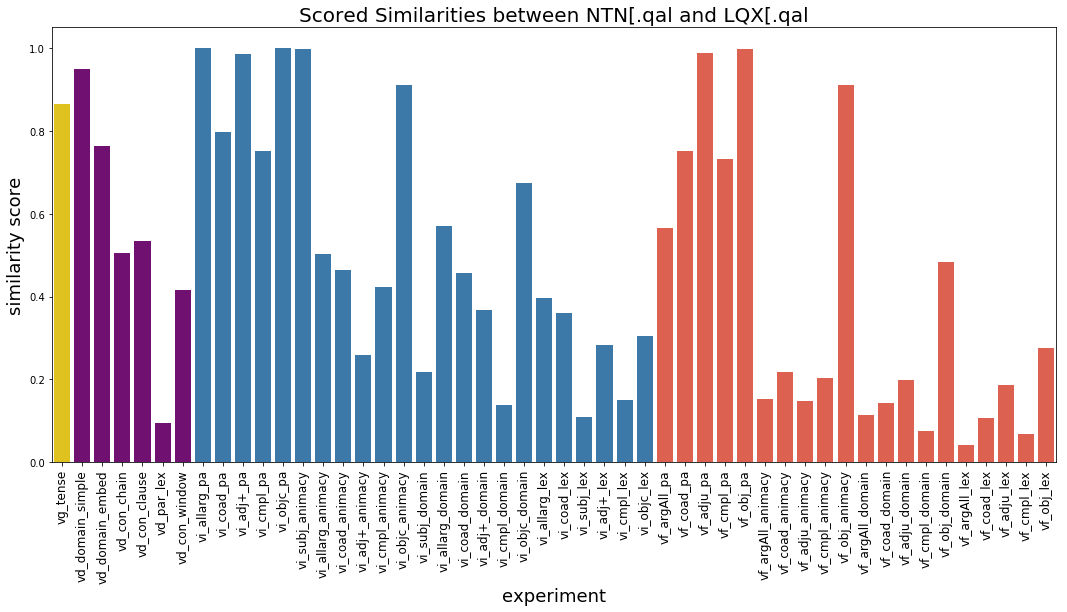

In [125]:
give_take = get_sim_experiments('NTN[.qal', 'LQX[.qal')

**Now we highlight the particular differences in similarity between sets of pairs. Or in other words, we examine the difference in similarity patterns between two pairs of words.**

**<FH[.qal**

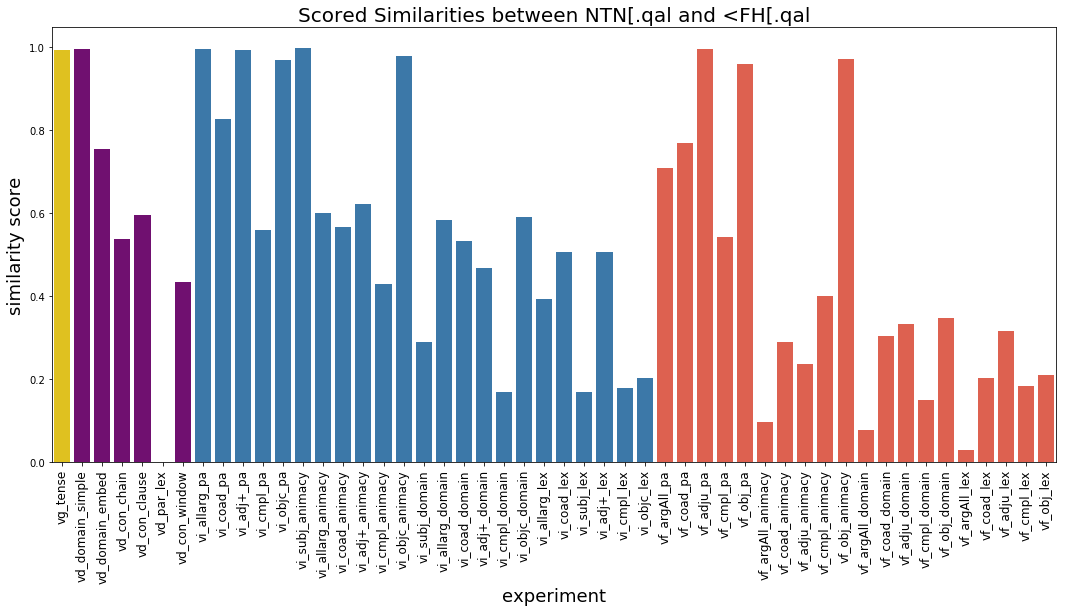

In [126]:
give_make = get_sim_experiments('NTN[.qal', '<FH[.qal')

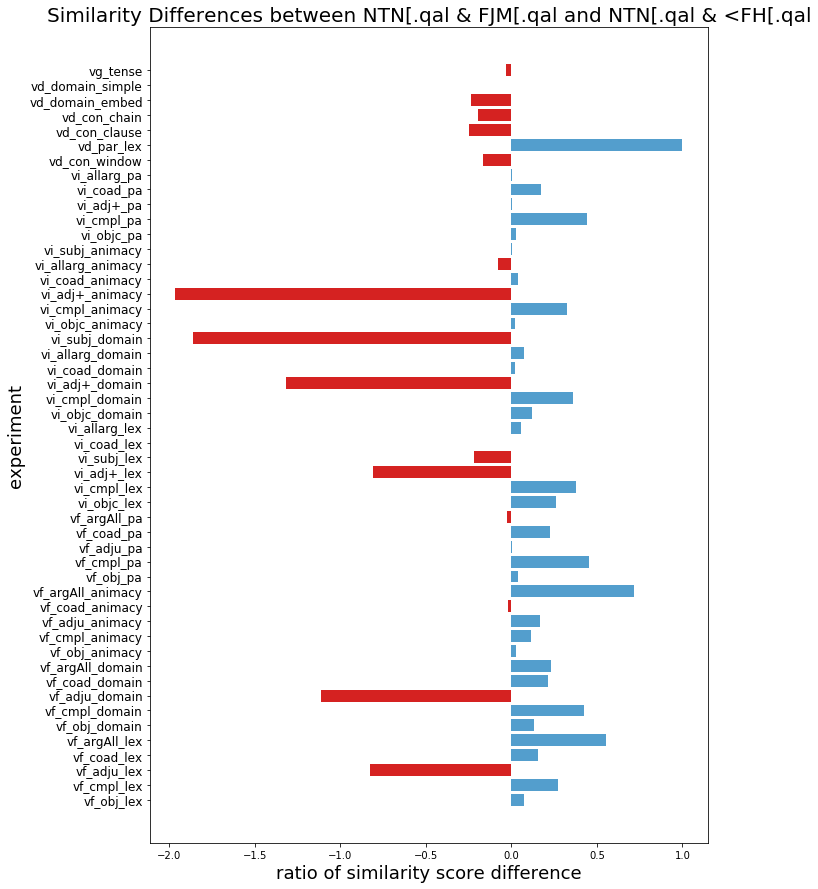

In [127]:
compareChange(('NTN[.qal', 'FJM[.qal'), ('NTN[.qal', '<FH[.qal'))

##### Observations
**TO DO**

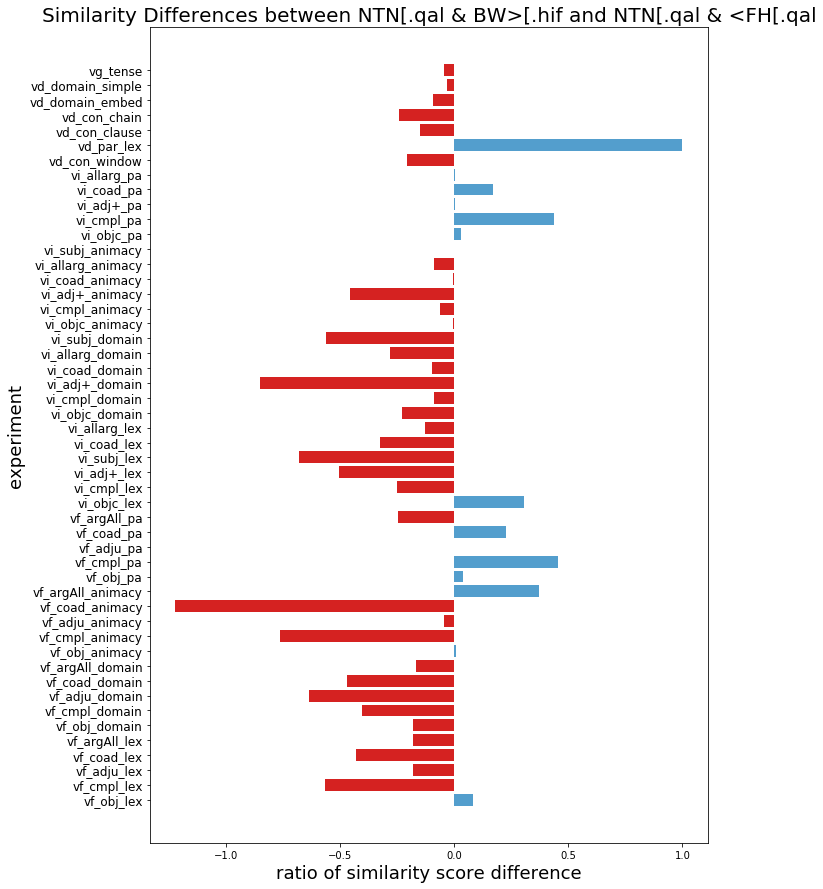

In [128]:
compareChange(('NTN[.qal', 'BW>[.hif'), ('NTN[.qal', '<FH[.qal'))

##### Observations
**To do**

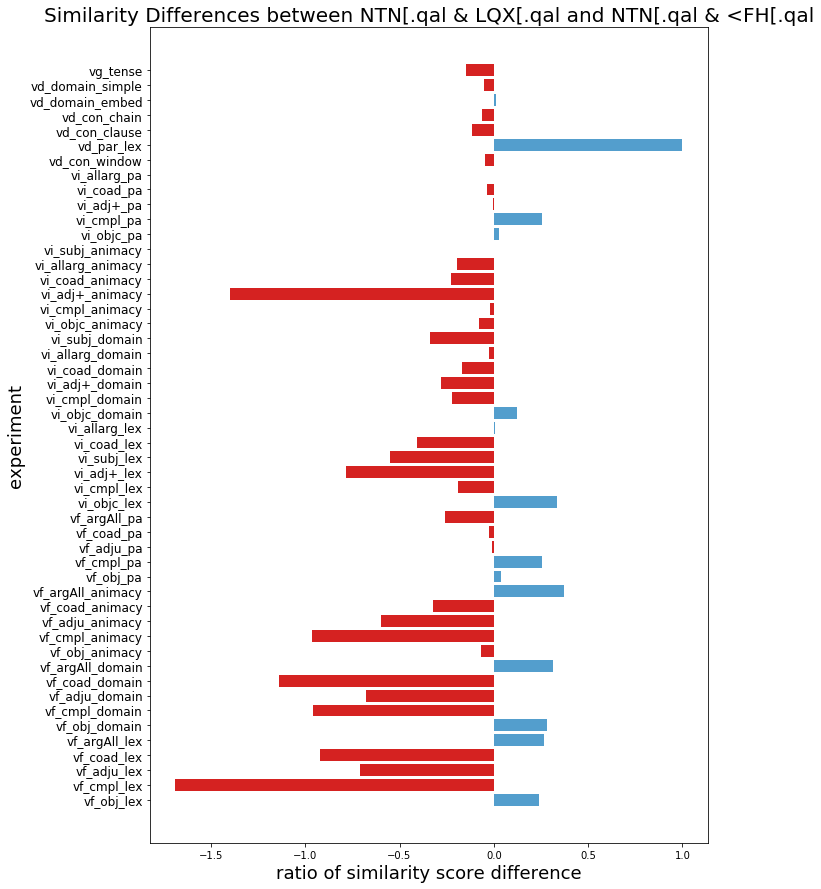

In [129]:
compareChange(('NTN[.qal', 'LQX[.qal'), ('NTN[.qal', '<FH[.qal'))

Looking over the graphs, vf_argAll_animacy is consistently higher across all comparisons. Why might that be the case?

In [130]:
top_give = set(spaces['vf_argAll_animacy'].pmi['NTN[.qal'].sort_values(ascending=False).head(20).index)
top_set = set(spaces['vf_argAll_animacy'].pmi['FJM[.qal'].sort_values(ascending=False).head(20).index)

top_give & top_set

{'Cmpl.>L_inanimate|Objc.inanimate',
 'Cmpl.BJN/_inanimate|Objc.inanimate',
 'Cmpl.B_animate|Objc.inanimate',
 'Cmpl.K_inanimate|Objc.inanimate',
 'Objc.animate|adj+.K_animate'}

In [131]:
top_give = set(spaces['vf_argAll_animacy'].pmi['NTN[.qal'].sort_values(ascending=False).head(25).index)
top_move = set(spaces['vf_argAll_animacy'].pmi['BW>[.hif'].sort_values(ascending=False).head(25).index)

top_give & top_move

{'Cmpl.>L_animate|Objc.inanimate',
 'Cmpl.>L_inanimate|Objc.inanimate',
 'Cmpl.L_animate|Objc.inanimate'}

**HJH**

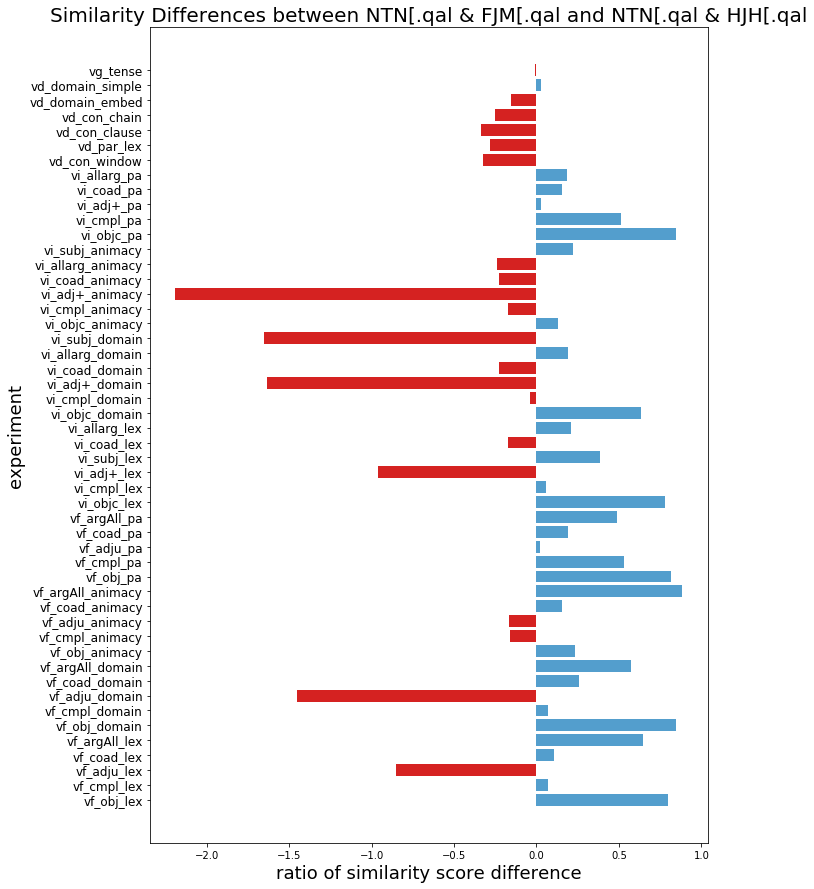

In [132]:
compareChange(('NTN[.qal', 'FJM[.qal'), ('NTN[.qal', 'HJH[.qal'))

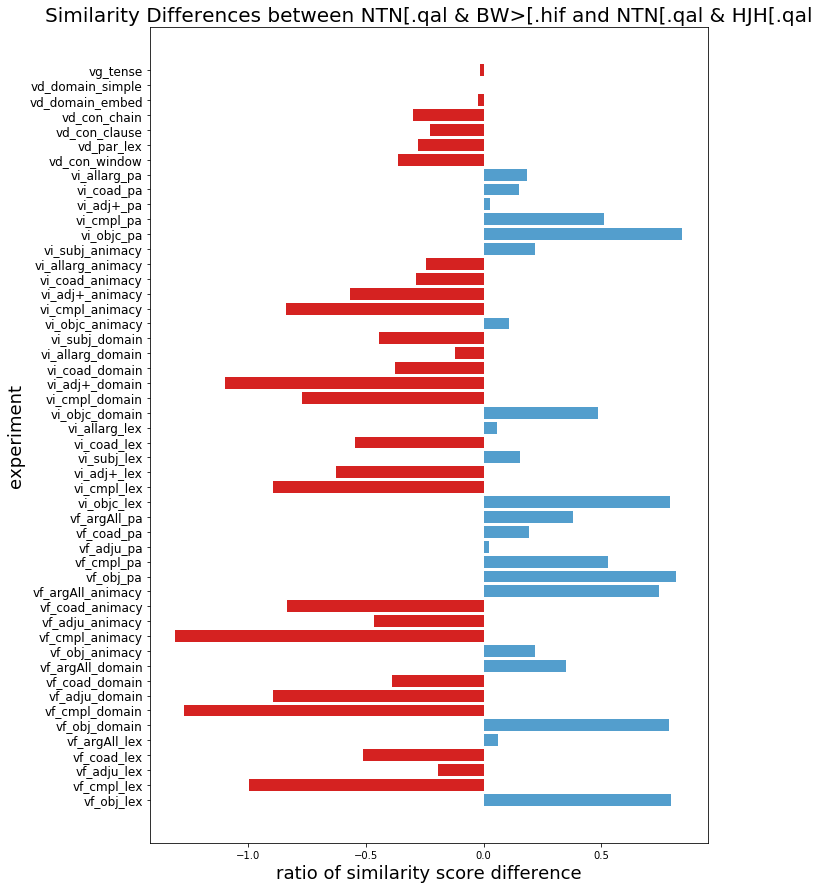

In [133]:
compareChange(('NTN[.qal', 'BW>[.hif'), ('NTN[.qal', 'HJH[.qal'))

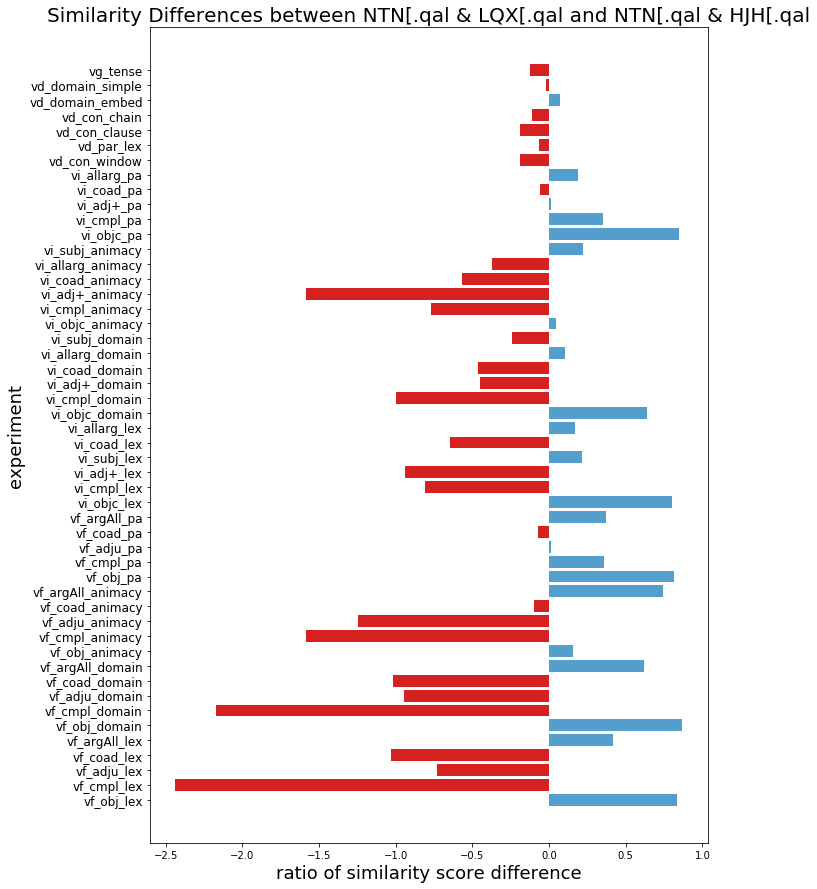

In [134]:
compareChange(('NTN[.qal', 'LQX[.qal'), ('NTN[.qal', 'HJH[.qal'))